# Unresolved Binary Analysis Using Photometric Data
**DESCRIPTION** This project is meant to experiment as to whether a mixture of isochrone models fit using an Expectation-Maximization Algorithm can sufficiently capture the fraction of unresolved binaries in an open cluster like the Pleiades Cluster.

Let's first start with our normal import statements. Make sure that while running the Jupyter notebook, you are selected to the `iso_env` kernel that you created earlier with the `./install.sh` script.

In [1]:
import logging
import pandas as pd
import matplotlib.pyplot as plt

from analyzer import GaiaAnalyzer, TESSAnalyzer
from analyzer import MISTFitter, BinaryMixtureFitter
from downloader import LightCurveExtractor
from generator import IsochroneSynthesizer

%load_ext autoreload
%autoreload 2

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.
/Users/jeremyng/conda/envs/iso_env/lib/python3.9/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


The command below just applies some neat formatting to the table for graphs.

In [2]:
# some statements to make the figures look nicer 
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'axes.linewidth' : 1,
                     'ytick.major.width' : 1,
                     'ytick.minor.width' : 1,
                     'xtick.major.width' : 1,
                     'xtick.minor.width' : 1,
                     'xtick.labelsize': 10, 
                     'ytick.labelsize': 10,
                     'axes.labelsize': 12,
                    
                     'font.family': 'Serif',
                     'figure.figsize': (10, 6)
                    })

### Part 1: Single-Star Isochrone Fitting

To get started, let's first get Gaia data from the Pleiades. Membership was determined in a paper that is linked [here](https://arxiv.org/abs/2110.03837v1) and was already predownloaded in the `pleiades_downloader.ipynb` notebook. If you notice, there appears to be a distinct "single" isochrone track with a second thinner one to its right at approximately ~0.75 magnitudes higher, which aligns with intuition.

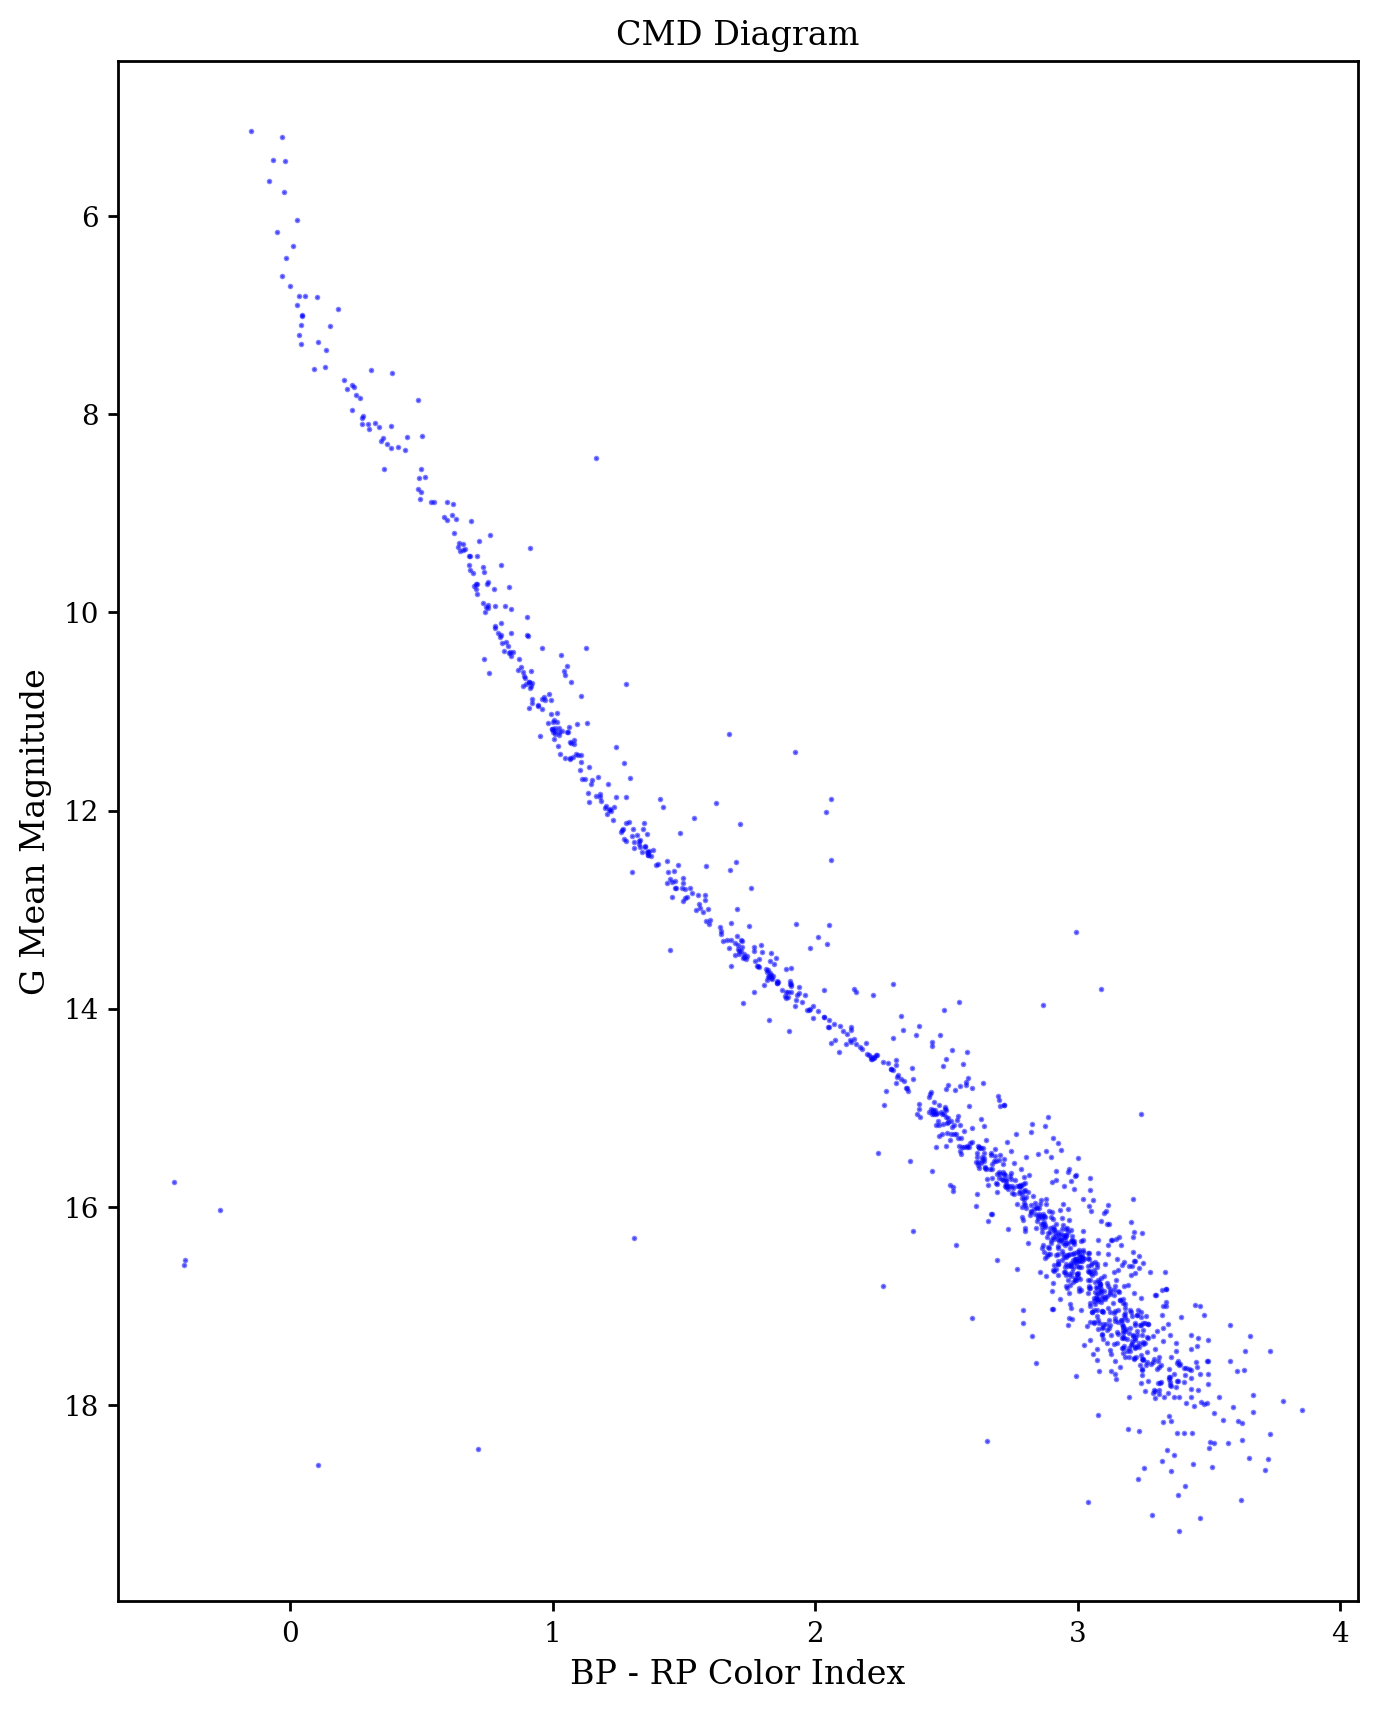

(<Figure size 800x1000 with 1 Axes>,
 <Axes: title={'center': 'CMD Diagram'}, xlabel='BP - RP Color Index', ylabel='G Mean Magnitude'>)

In [3]:
# Downloading Gaia data.
gaia_analyzer = GaiaAnalyzer(filename='data/gaia.csv')
gaia_analyzer.get_data()

# Displaying Gaia data.
df = gaia_analyzer.get_data().copy()
gaia_analyzer.plot_hr_diagram(show=True)

This is a nice CMD already! Now, let's fit a single-star evolution track isochrone to this now. To achieve this, we do a custom MCMC fit using a grid of MIST isochrones supplied in the `isochrones` package.

100%|██████████| 2000/2000 [05:57<00:00,  5.60it/s]
2025-11-13 12:13:38,723 - WARNING - Too few points to create valid contours
2025-11-13 12:13:38,770 - WARNING - Too few points to create valid contours


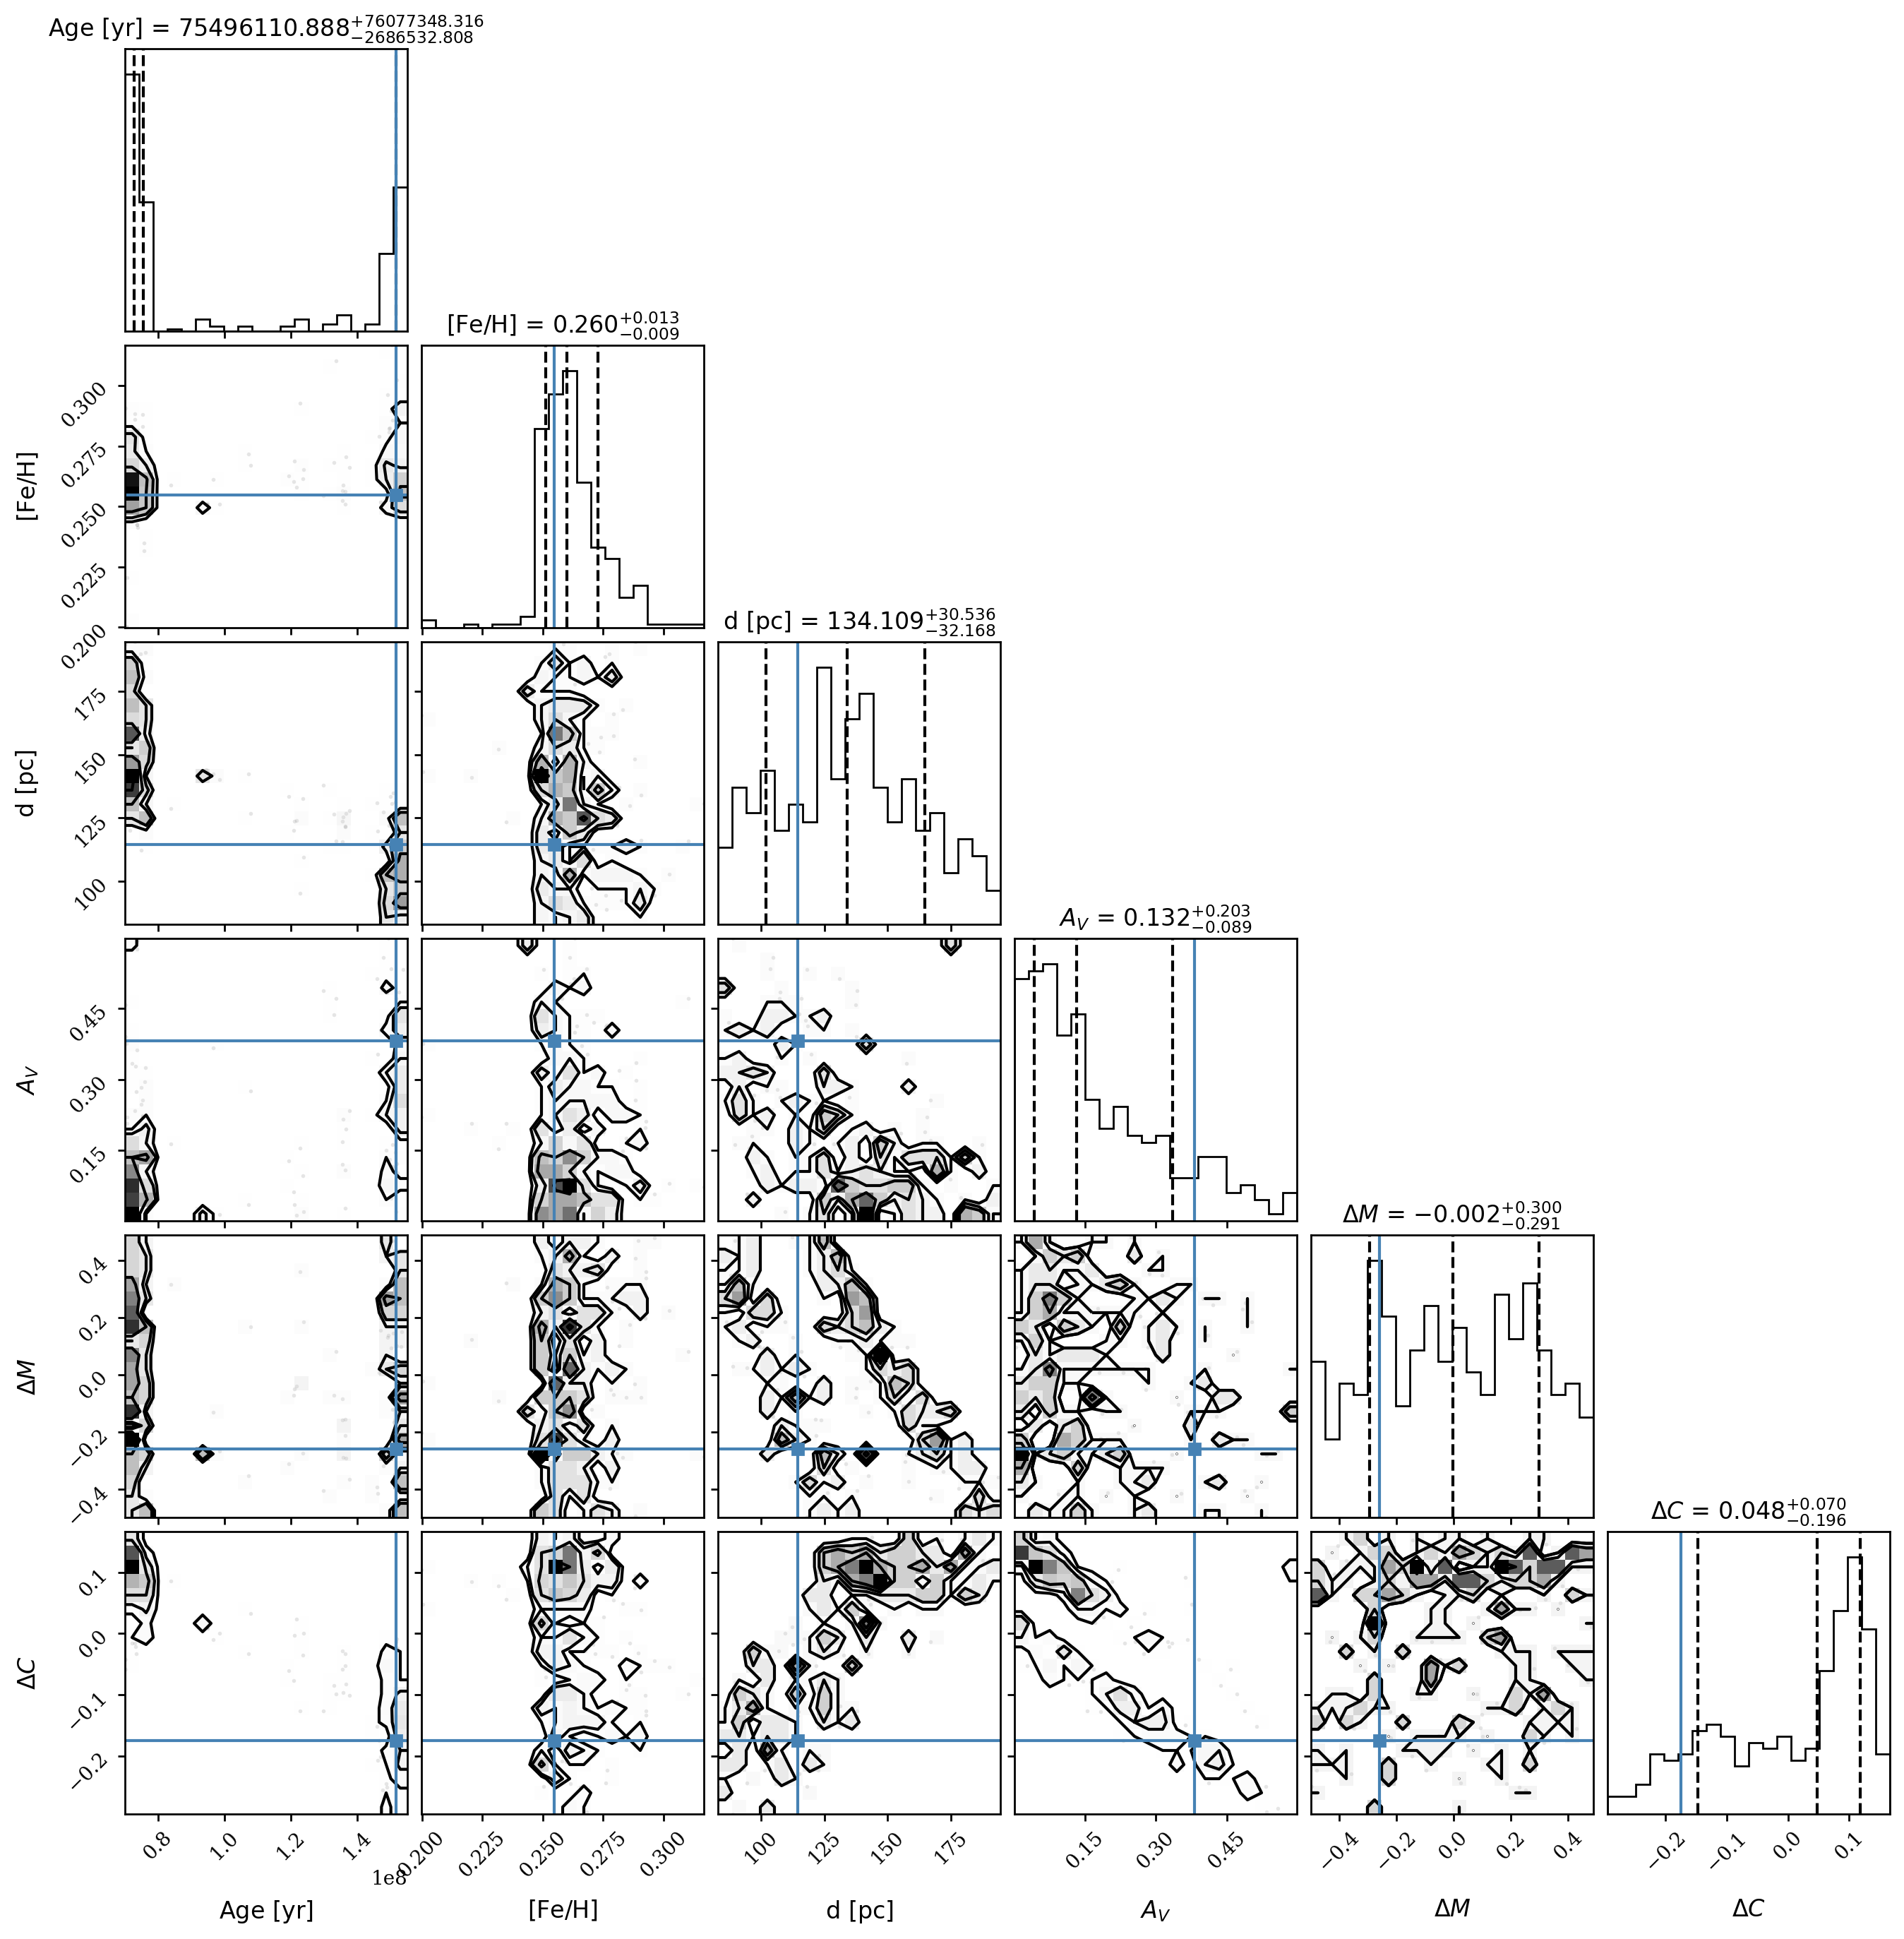

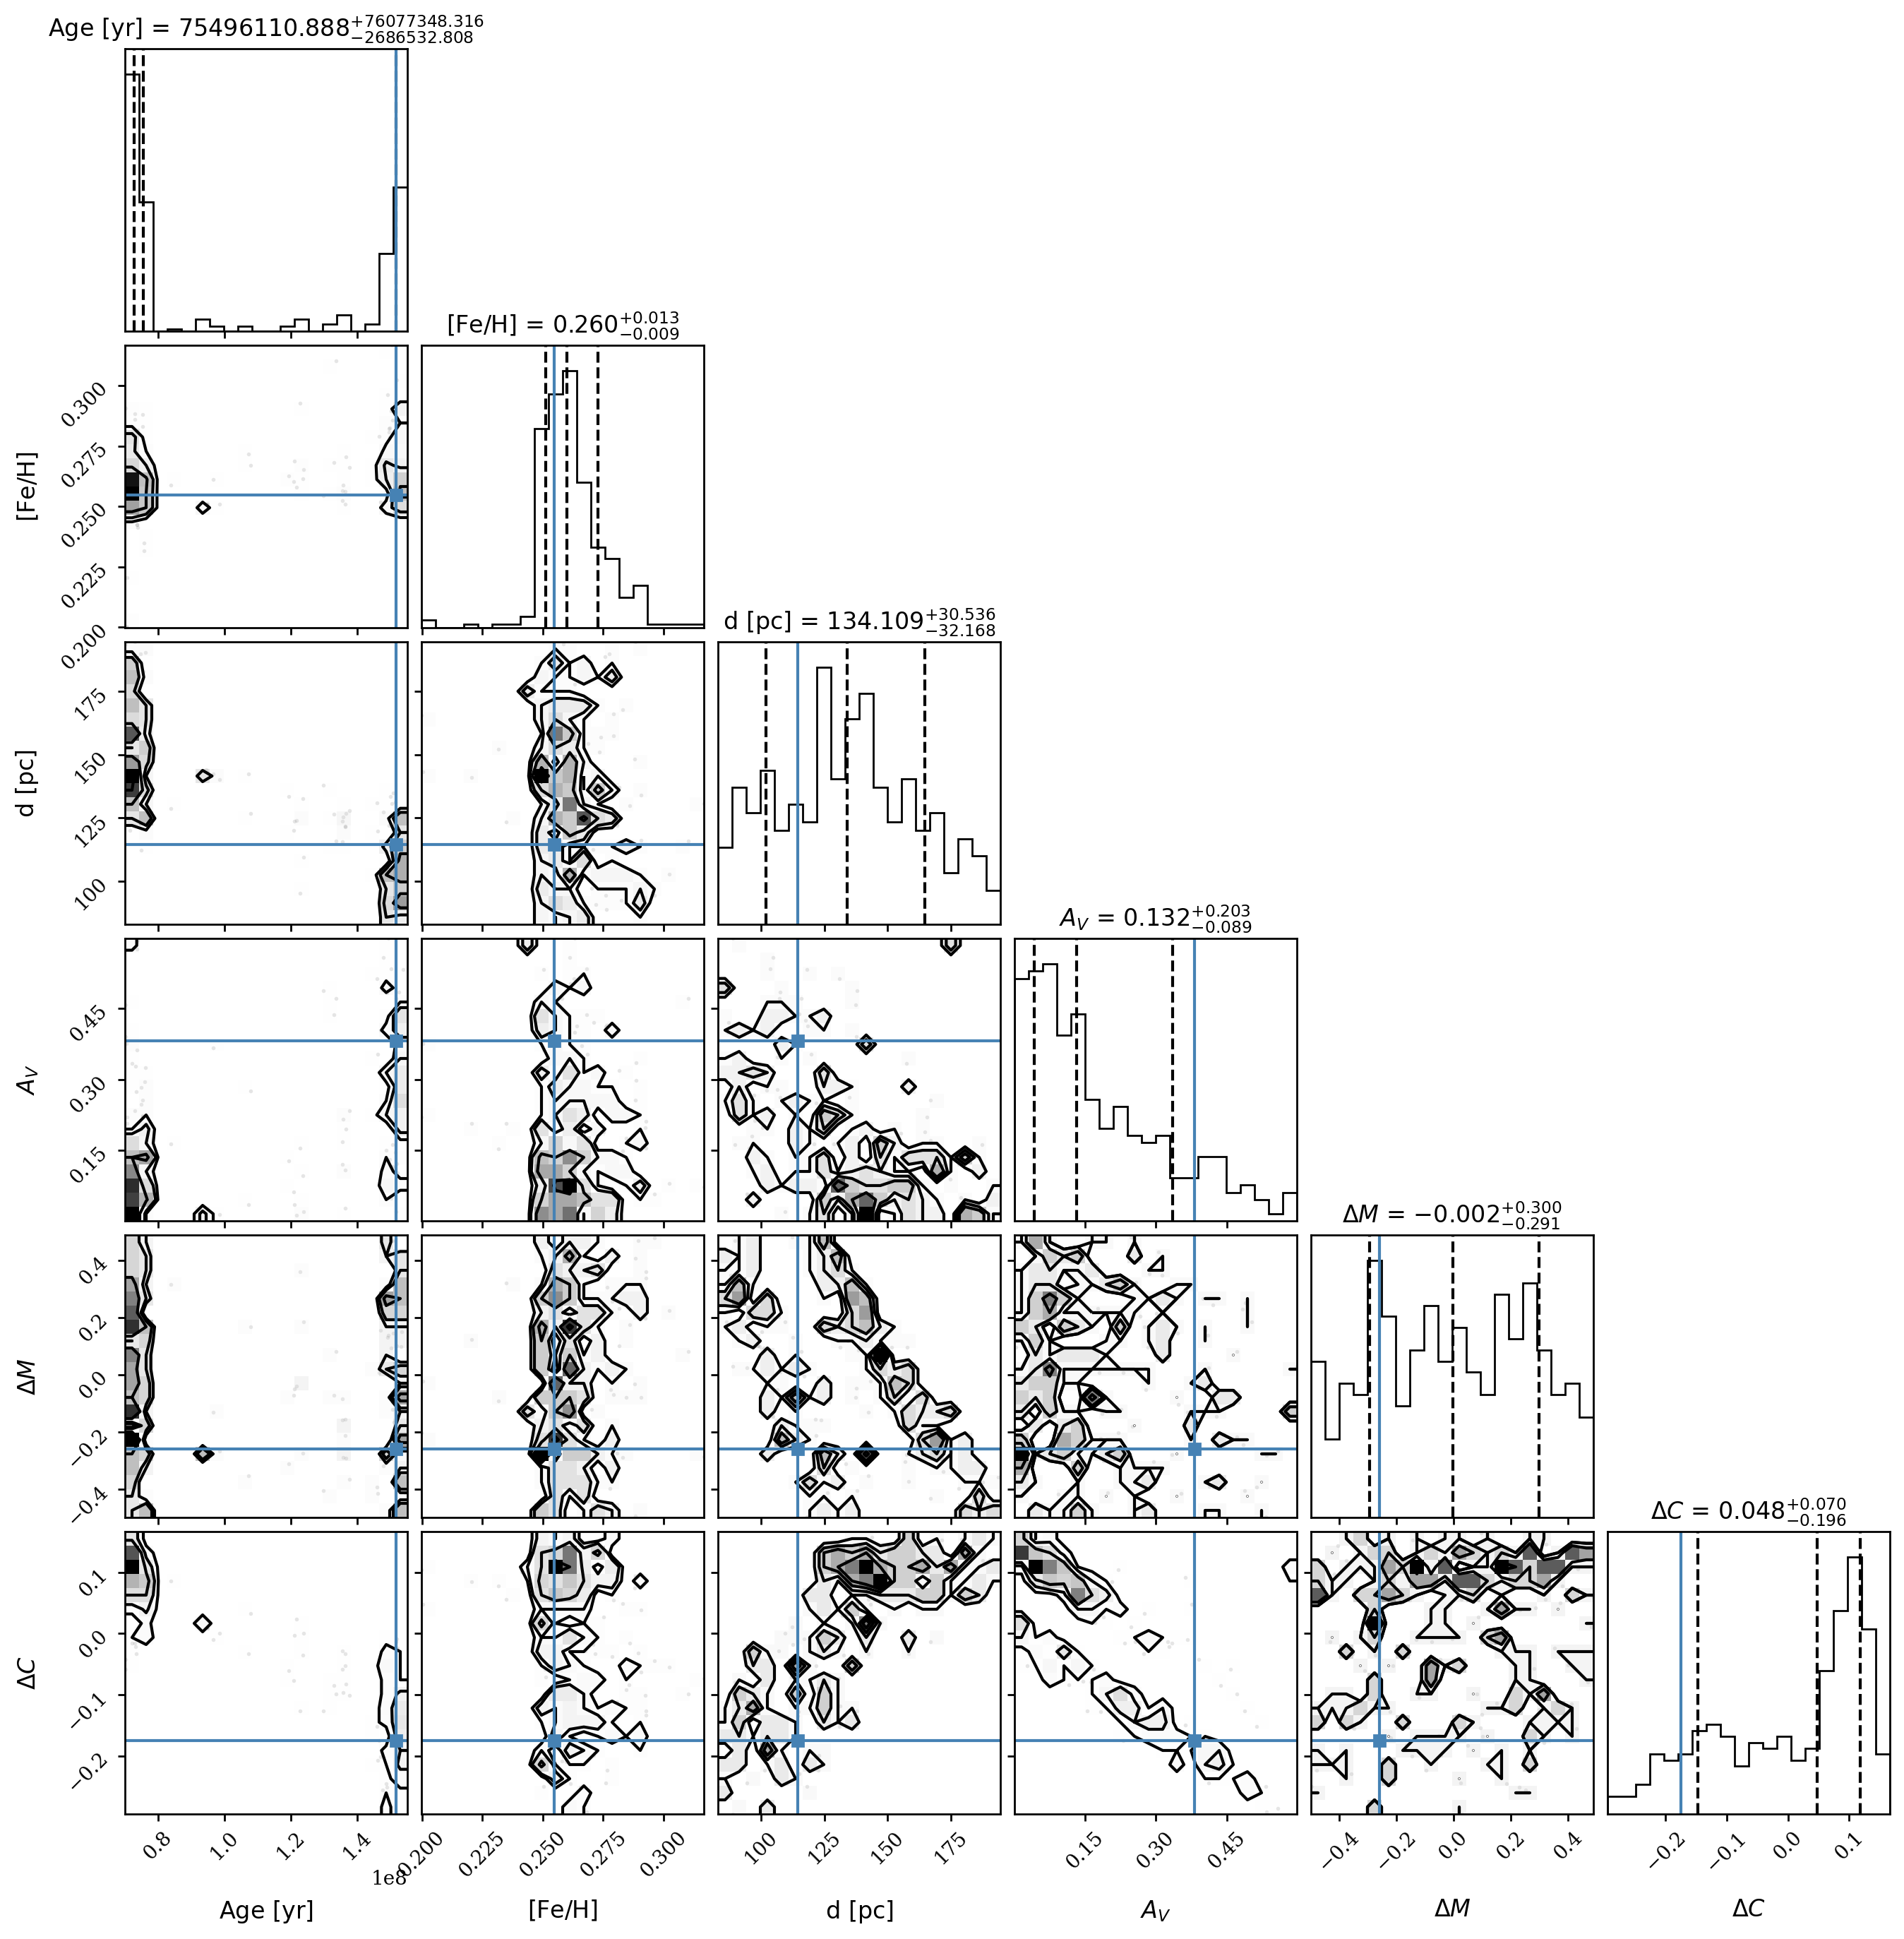

In [4]:
# Let's start with a nice simple MCMC.
fitter = MISTFitter(data=df, age_range=(70e6, 160e6))
sampler = fitter.sample_cluster(n_walkers=32, n_burn=200, n_steps=2000)

# Let's display the corner plot now!
fitter.plot_corner(sampler, discard=200, thin=200)

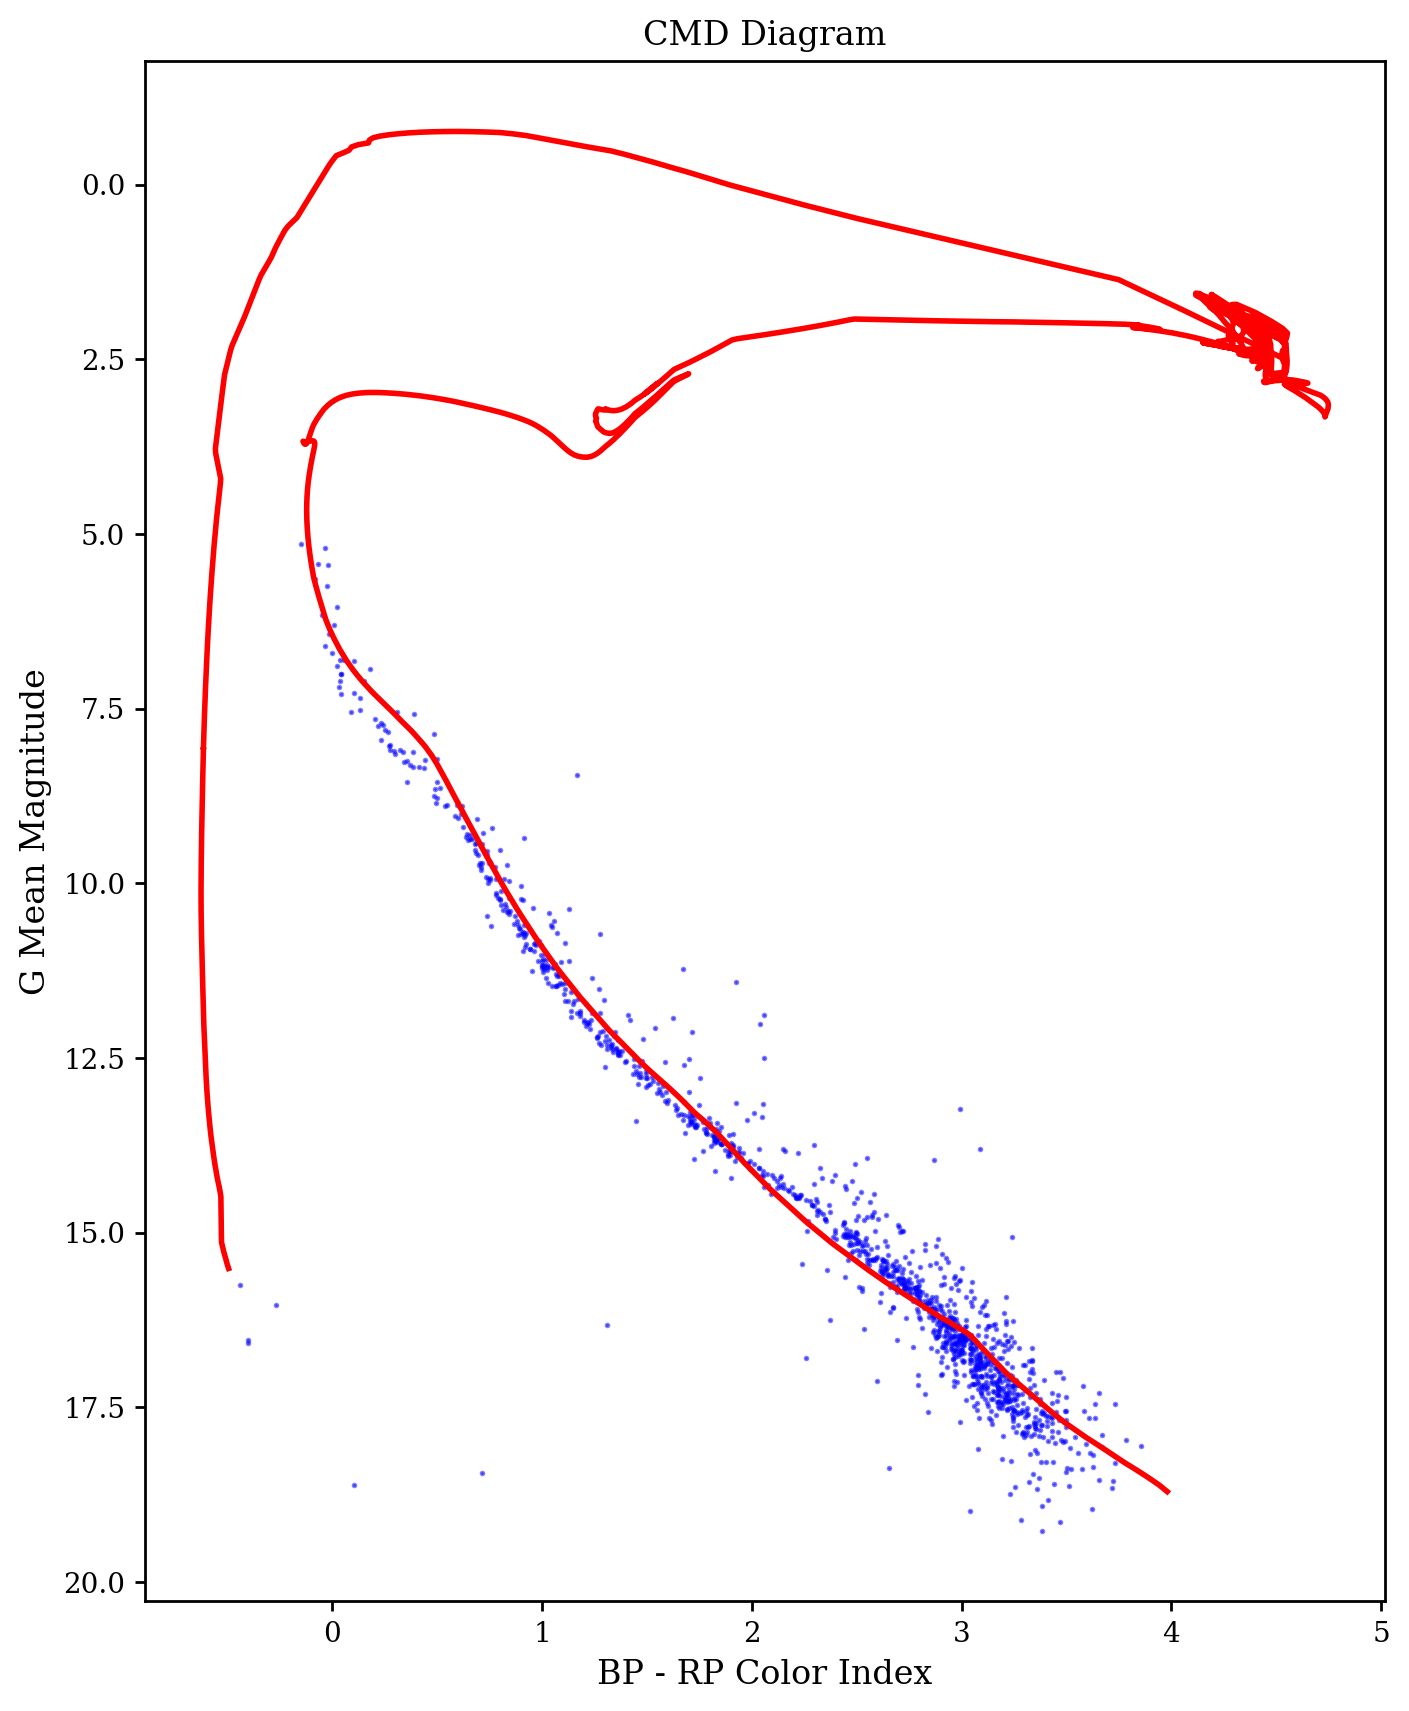

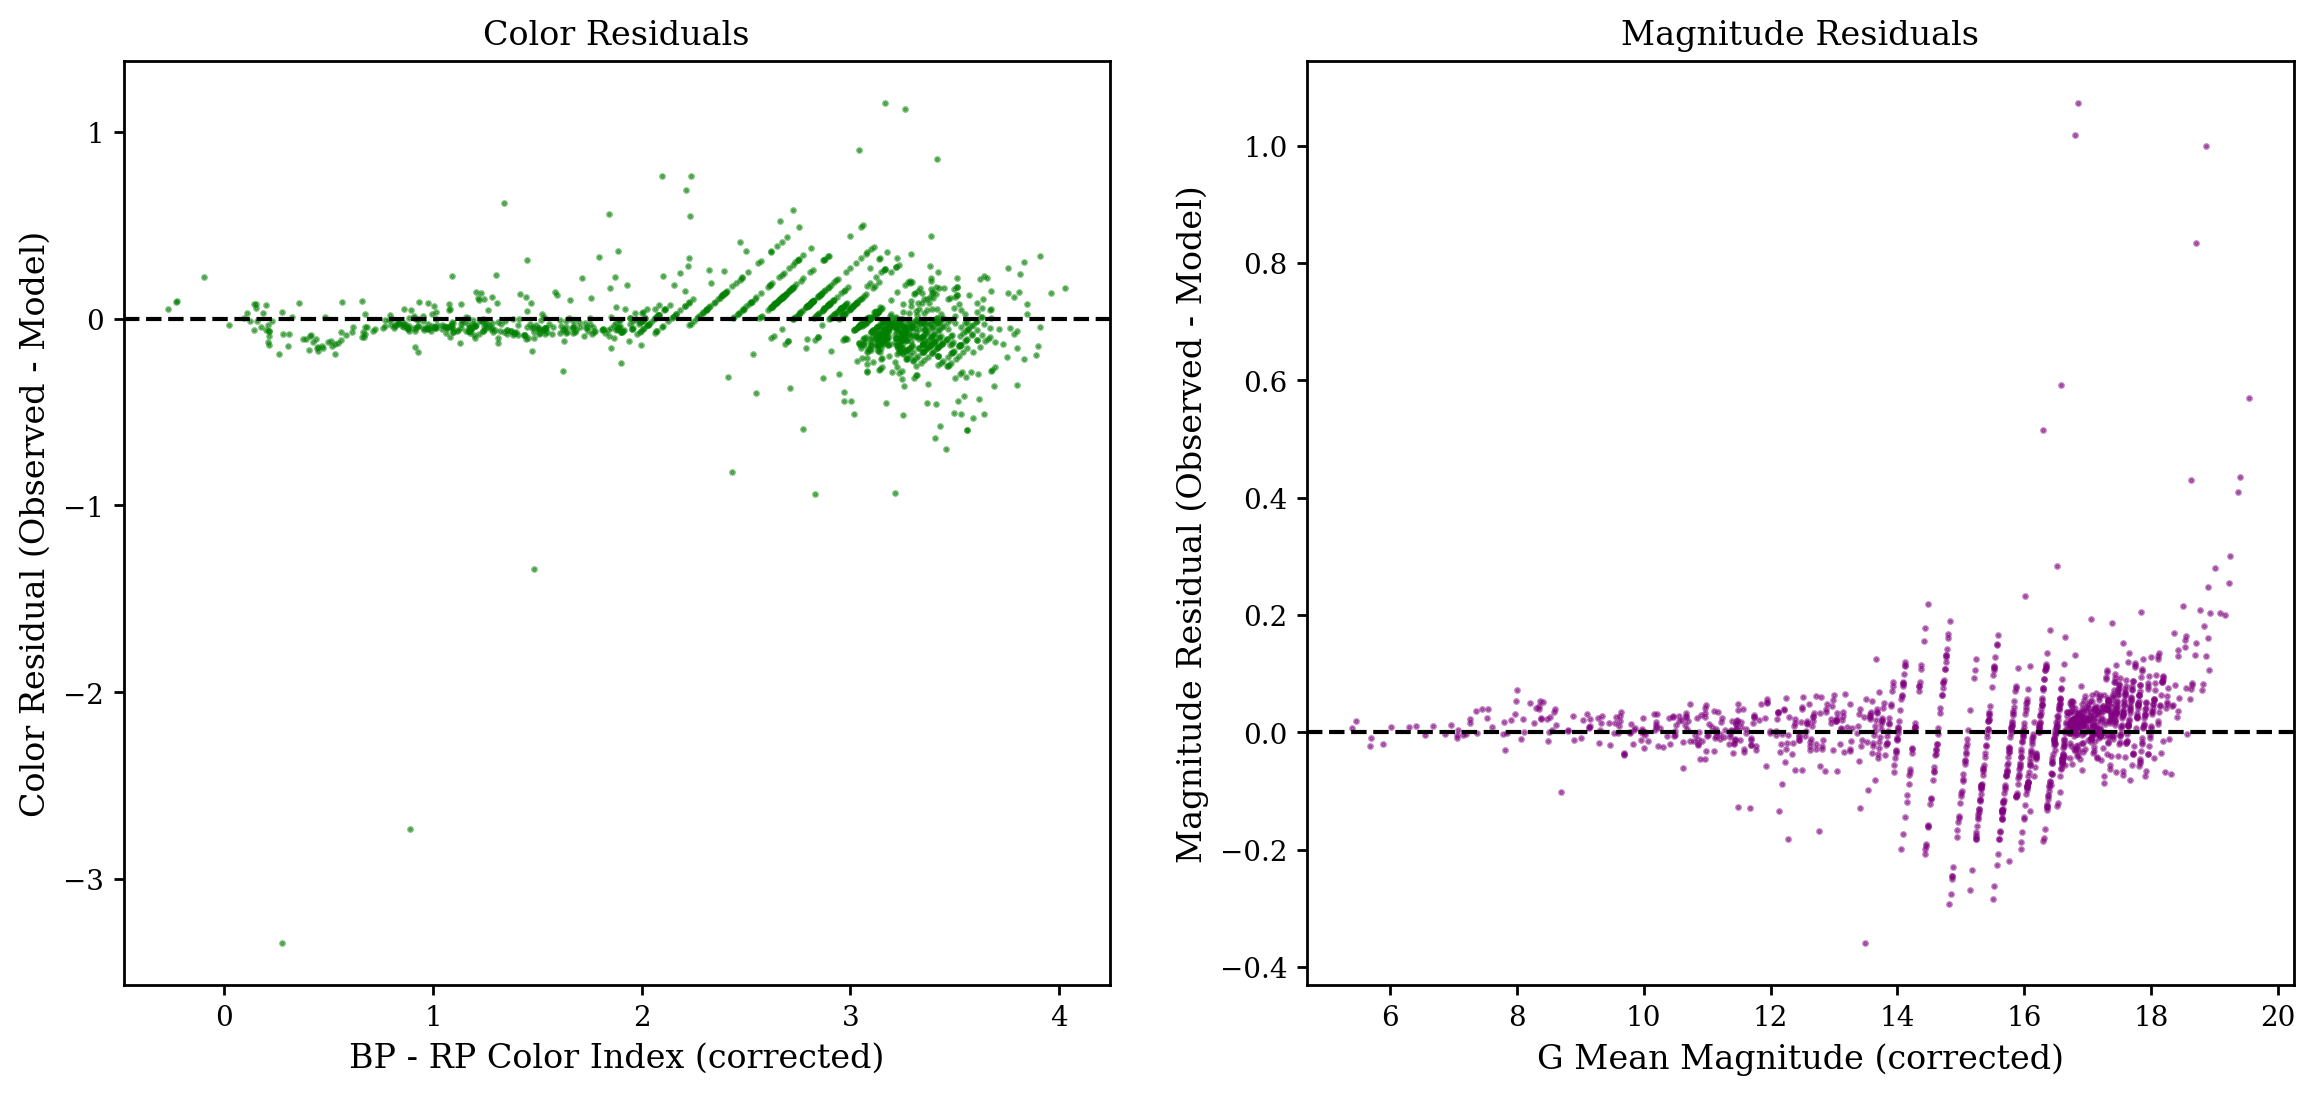

2025-11-13 12:13:40,089 - INFO - Best cluster parameters:
Age=1.52e+08 yr, [Fe/H]=0.25, Distance=114.4 pc, A_V=0.38


In [5]:
# Now, we can extract the best parameters of the model and also plot residuals.
best_params = fitter.get_best_model()
fitter.plot_isochrone(best_params)
fitter.plot_residuals(theta=best_params)

logging.info(f"Best cluster parameters:\nAge={best_params[0]:.2e} yr, [Fe/H]={best_params[1]:.2f}, "
      f"Distance={best_params[2]:.1f} pc, A_V={best_params[3]:.2f}")

Like in Lab 3 for the Rotation Curve analysis, we can actually plot many possible isochrones at once that comply with the $-\chi^2$ cutoff we've chosen.

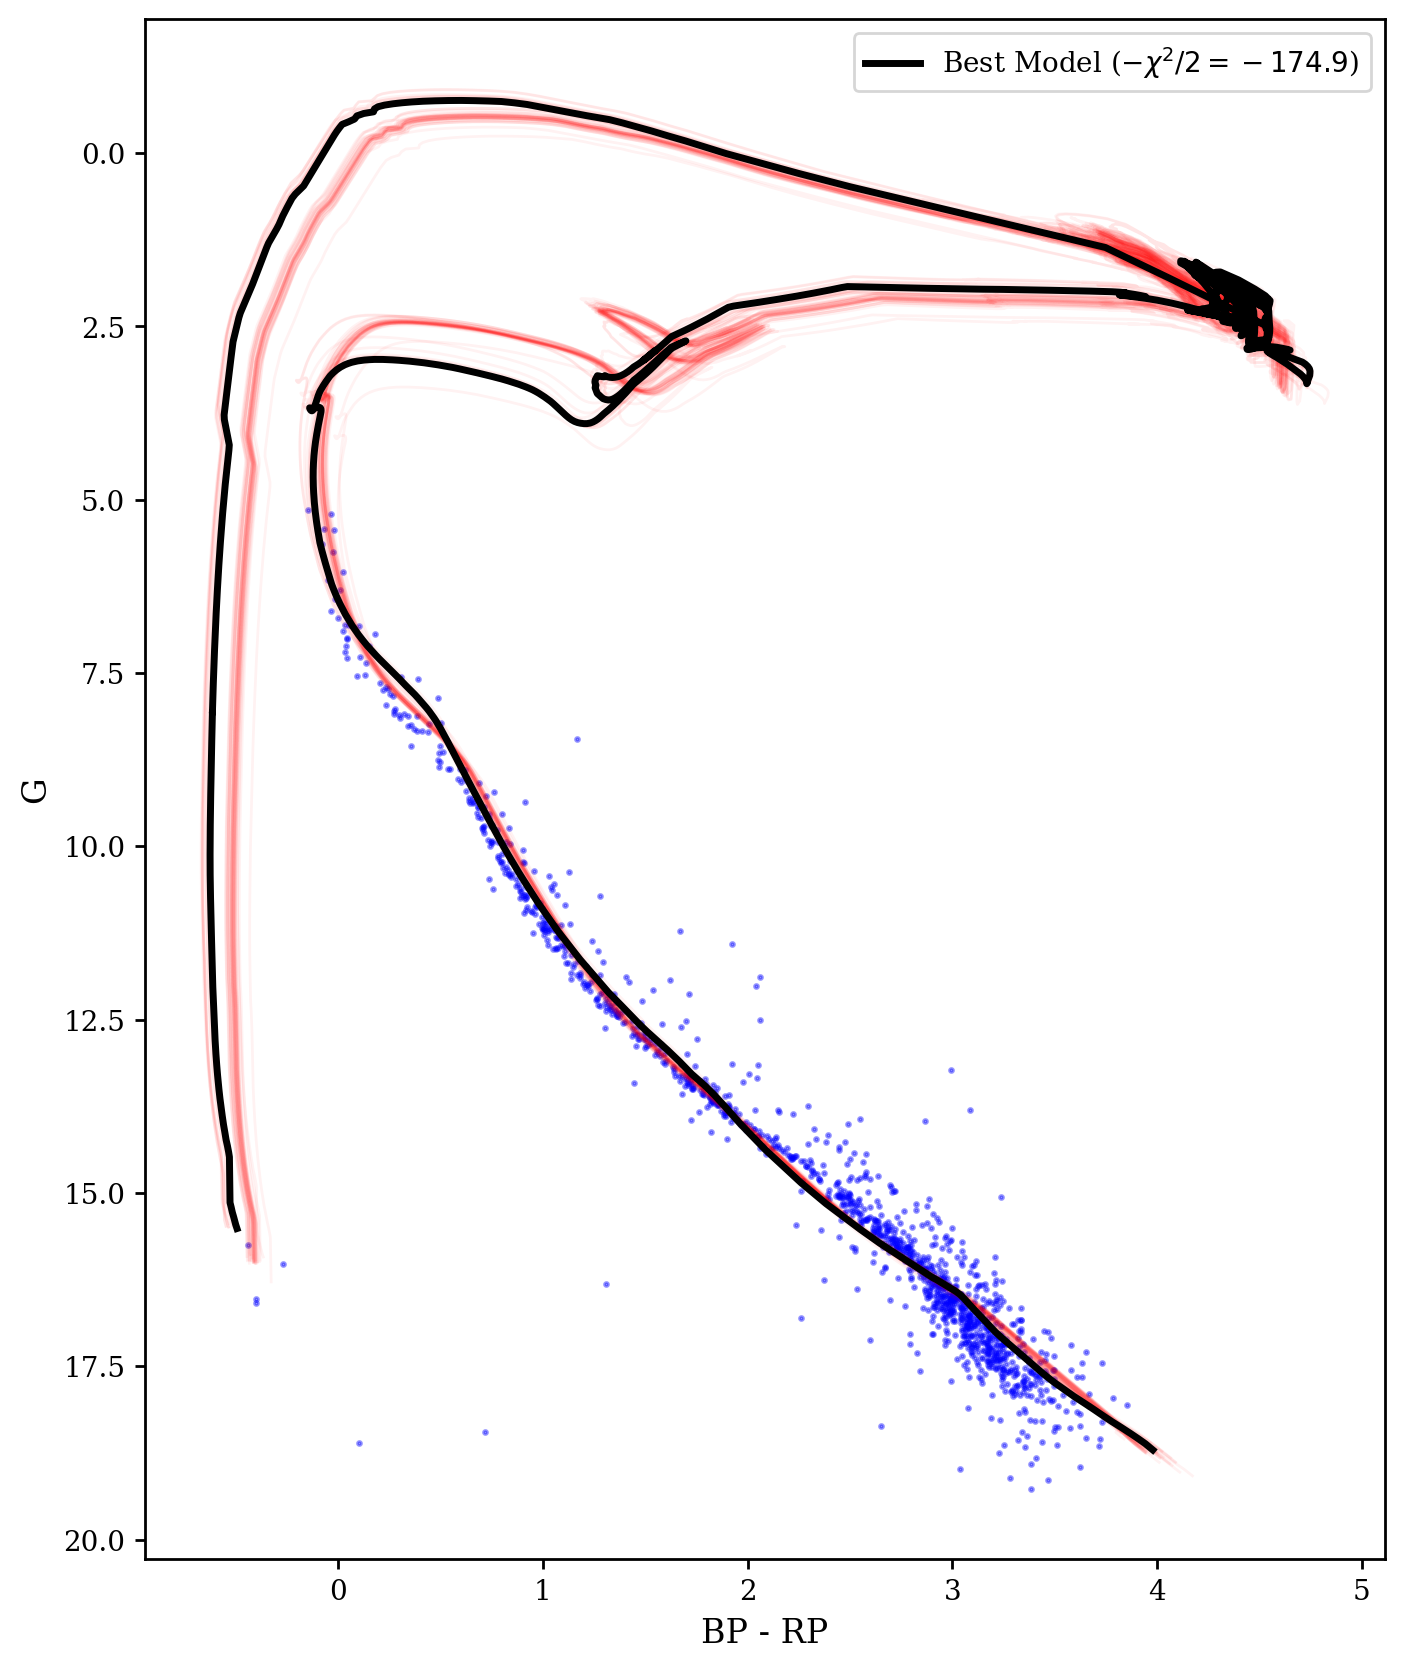

(<Figure size 800x1000 with 1 Axes>, <Axes: xlabel='BP - RP', ylabel='G'>)

In [6]:
# Pretty plotting of many proposal isochrones.
fitter.plot_good_isochrones(chi2_cutoff=1)

We can also get the Bayesian Information Criterion (BIC) just like Lab 4 to evaluate the strength of our model.

In [7]:
fitter.bic()

392.72074762258757

### Part 2: Binary Mixture Model
​We construct a binary isochrone by adding the fluxes of a primary star and a hypothetical companion, and use a mixture model that looks like:
$$
    p(c_i, m_i \mid \theta) = \sum_{k \in \{\text{single, binary, field}\}} \pi_k p_k(c_i, m_i \mid \theta)
$$
where $\pi_k$ is the mixture weight for the probability density function $p_k$ and the parameters
$$
    \theta = (\text{age, [Fe/H], $d$, $A_V$, $\Delta M$, $\Delta C$})
$$

In [8]:
# Use the previous single star isochrone fit as a prior to inform the binary mixture fit.
binary_fitter = BinaryMixtureFitter(data=df)
binary_fitter.fit(theta=fitter.get_best_model())

logging.info(f"The optimal fit weights are: [f_single, f_binary, f_field] = {binary_fitter.get_mixture_weights()}")

2025-11-13 12:13:40,731 - INFO - Starting EM fit
2025-11-13 12:13:40,732 - INFO - Initial weights: [0.8 0.2 0. ]
  0%|          | 0/40 [00:00<?, ?it/s]2025-11-13 12:13:43,230 - INFO - lnL stats | single: mean=-1.31 max=0.26, binary: mean=-1.43 max=1.55, field: mean=0.00 max=0.00
2025-11-13 12:13:43,231 - INFO - Updated mixture weights: [6.74760686e-01 3.24849754e-01 3.89559797e-04]
  2%|▎         | 1/40 [00:02<01:37,  2.50s/it]2025-11-13 12:13:43,235 - INFO - lnL stats | single: mean=-1.31 max=0.26, binary: mean=-1.43 max=1.55, field: mean=0.00 max=0.00
2025-11-13 12:13:43,235 - INFO - Updated mixture weights: [0.58073682 0.39871173 0.02055146]
2025-11-13 12:13:43,238 - INFO - lnL stats | single: mean=-1.31 max=0.26, binary: mean=-1.43 max=1.55, field: mean=0.00 max=0.00
2025-11-13 12:13:43,238 - INFO - Updated mixture weights: [0.48608116 0.41768405 0.09623478]
2025-11-13 12:13:43,240 - INFO - lnL stats | single: mean=-1.31 max=0.26, binary: mean=-1.43 max=1.55, field: mean=0.00 max=0

2025-11-13 12:13:43,368 - INFO - lnL stats | single: mean=-1.31 max=0.26, binary: mean=-1.43 max=1.55, field: mean=0.00 max=0.00


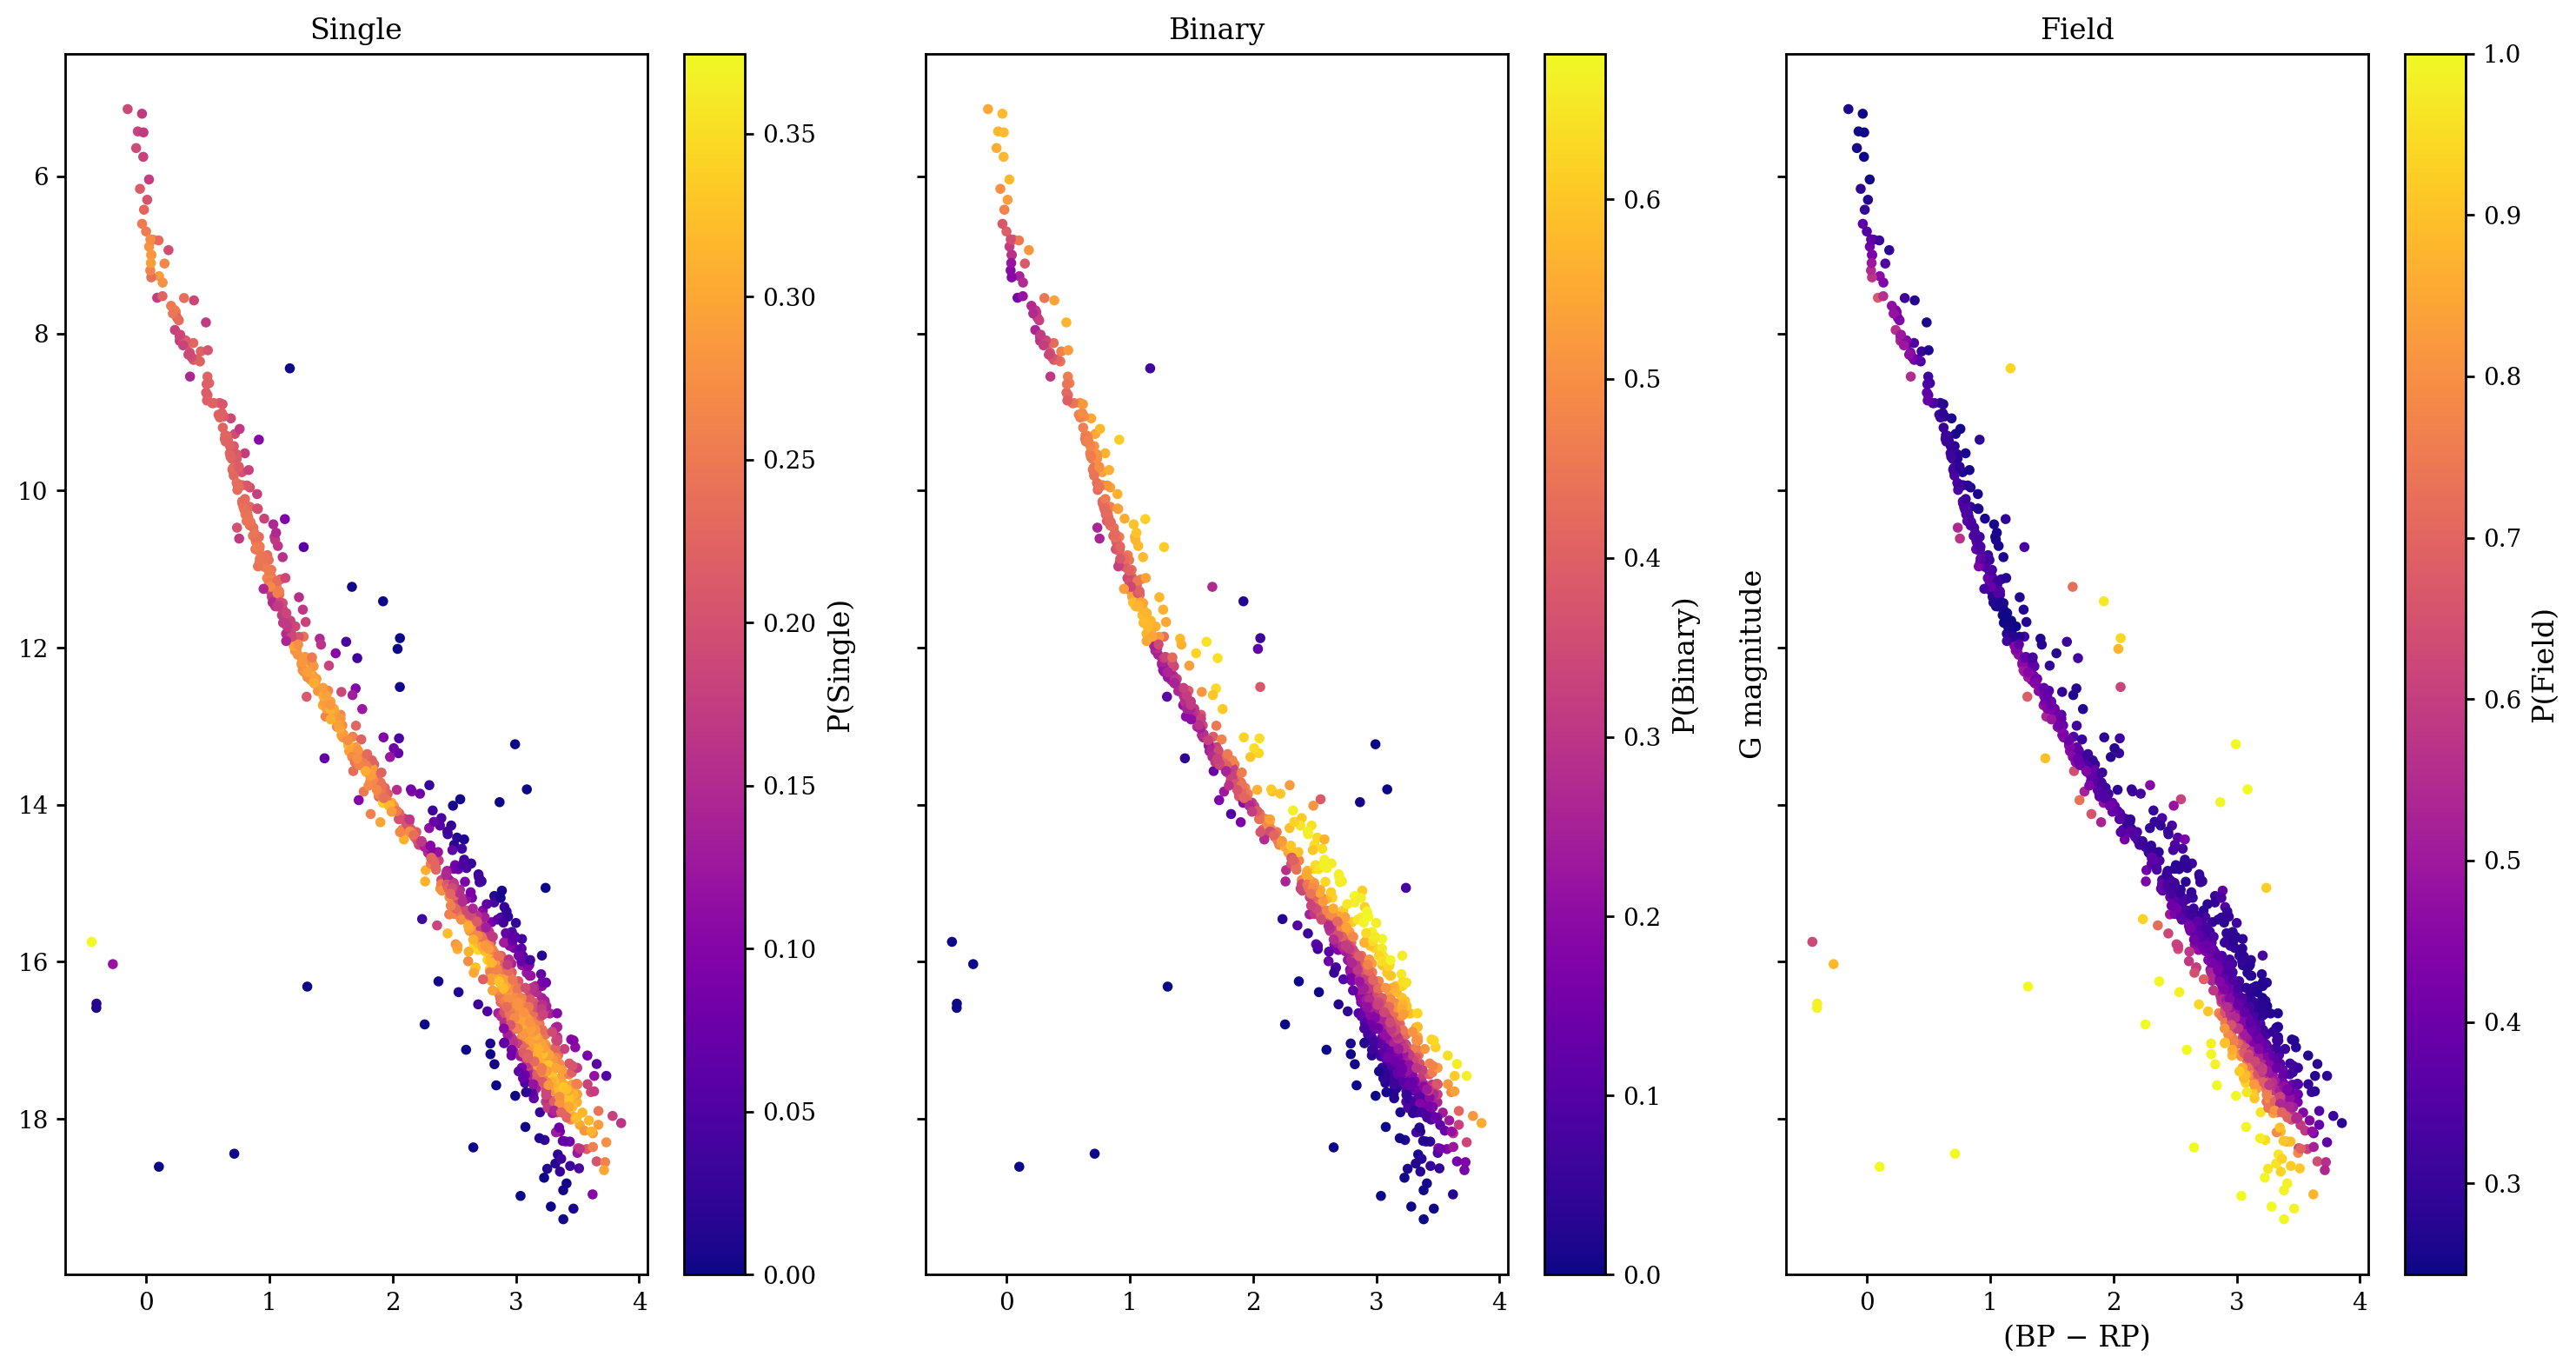

(<Figure size 1500x800 with 6 Axes>,
 <Axes: title={'center': 'Field'}, xlabel='(BP − RP)', ylabel='G magnitude'>)

In [9]:
# Let's see the probability distribution for each star now.
binary_fitter.plot()

To inspect how well the model did, let's compare the probabilities that the stars are binaries to a known catalog made by Chulkov et al. (2025) on resolving binaries using interferometry.

In [10]:
# No need for a specialized method for this
chulkov_df = pd.read_csv('data/chulkov_binaries.csv')
chulkov_source_ids = chulkov_df['Gaia1']

for source_id in chulkov_source_ids:
    try:
        logging.info(
            f"Probabilities for source {source_id}: {binary_fitter.get_probability(source_id)}"
        )
    except ValueError as e:
        logging.error(f"Oops! {e}")

2025-11-13 12:13:43,731 - INFO - lnL stats | single: mean=-1.31 max=0.26, binary: mean=-1.43 max=1.55, field: mean=0.00 max=0.00
2025-11-13 12:13:43,732 - INFO - Probabilities for source 66798496781121792: {'single': 0.1797130638846646, 'binary': 0.5731770746502276, 'field': 0.24710986146510774}
2025-11-13 12:13:43,735 - INFO - lnL stats | single: mean=-1.31 max=0.26, binary: mean=-1.43 max=1.55, field: mean=0.00 max=0.00
2025-11-13 12:13:43,736 - INFO - Probabilities for source 66507469798631808: {'single': 0.26436359328584896, 'binary': 0.3867986197979021, 'field': 0.34883778691624906}
2025-11-13 12:13:43,738 - INFO - lnL stats | single: mean=-1.31 max=0.26, binary: mean=-1.43 max=1.55, field: mean=0.00 max=0.00
2025-11-13 12:13:43,739 - INFO - Probabilities for source 64956127609464320: {'single': 0.27656656716532707, 'binary': 0.31412844139869545, 'field': 0.4093049914359774}
2025-11-13 12:13:43,741 - INFO - lnL stats | single: mean=-1.31 max=0.26, binary: mean=-1.43 max=1.55, fiel

We can also inspect using TESS short cadence variability data - notably, cross matching to see if any of the binaries in the Eclipsing Binary Catalog are also high probability.

In [11]:
# Only extract light curves of relevant TESS data for now.
lightcurve_analyzer = LightCurveExtractor(download_dir='lightcurves/')

ids = gaia_analyzer.extract_source_ids()
lightcurves = lightcurve_analyzer.extract_eb_lightcurves(ids)

2025-11-13 12:13:43,866 - INFO - Set Lightkurve download directory to lightcurves/
2025-11-13 12:13:43,867 - INFO - Using cached TESS EB catalog at data/tess_eb_catalog.csv
2025-11-13 12:14:13,644 - WARNING - No TIC match for 3 Gaia IDs: [67680850564641792, 70190249631846272, 52035251073077120]...
  0%|          | 0/1276 [00:00<?, ?it/s]2025-11-13 12:14:13,645 - INFO - Inspecting for EB membership: Gaia 3763976194792448 -> TIC 377056867
2025-11-13 12:14:13,646 - INFO - Inspecting for EB membership: Gaia 11352324413414016 -> TIC 416678539
2025-11-13 12:14:13,646 - INFO - Inspecting for EB membership: Gaia 19817739313090688 -> TIC 620010441
2025-11-13 12:14:13,646 - INFO - Inspecting for EB membership: Gaia 43733079289895424 -> TIC 434162270
2025-11-13 12:14:13,647 - INFO - Inspecting for EB membership: Gaia 46438771249859840 -> TIC 456886532
2025-11-13 12:14:13,647 - INFO - Inspecting for EB membership: Gaia 46922075328601216 -> TIC 15938971
2025-11-13 12:14:13,647 - INFO - Inspecting f

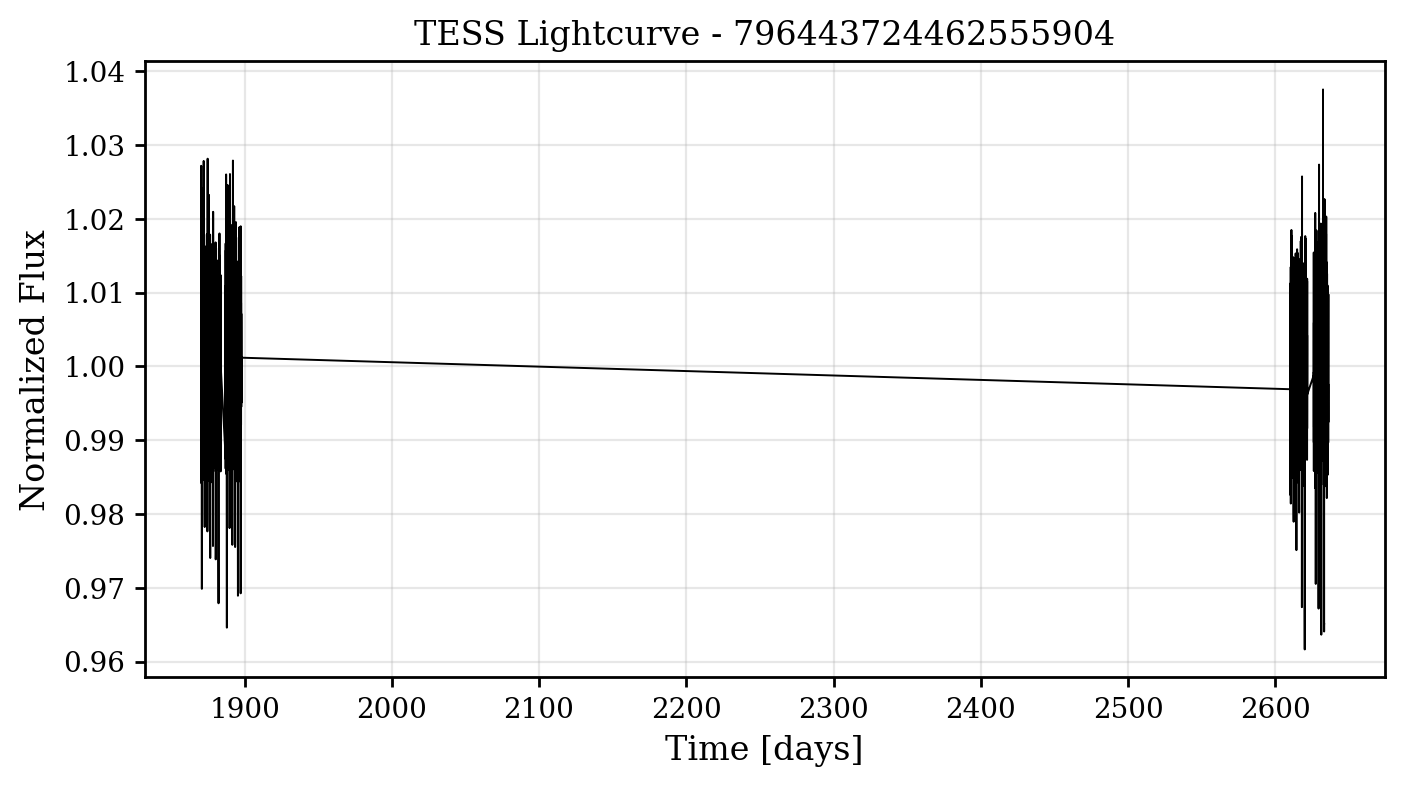

In [12]:
# You'll notice that we only should have one light curve here.
tess_analyzer = TESSAnalyzer(lightcurves=lightcurves)
tess_analyzer.batch_plot()

2025-11-13 12:14:37,408 - INFO - Analyzing lightcurve for 796443724462555904


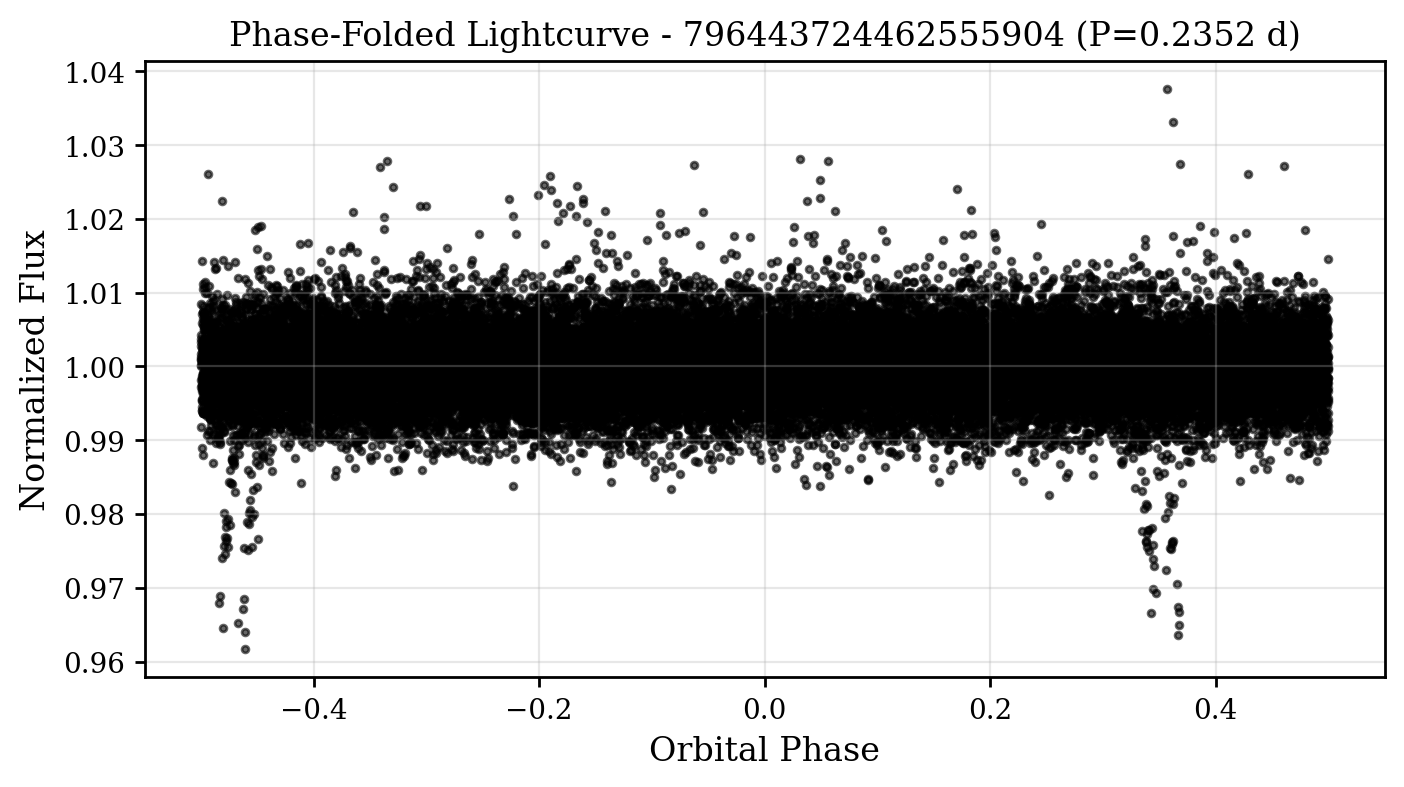

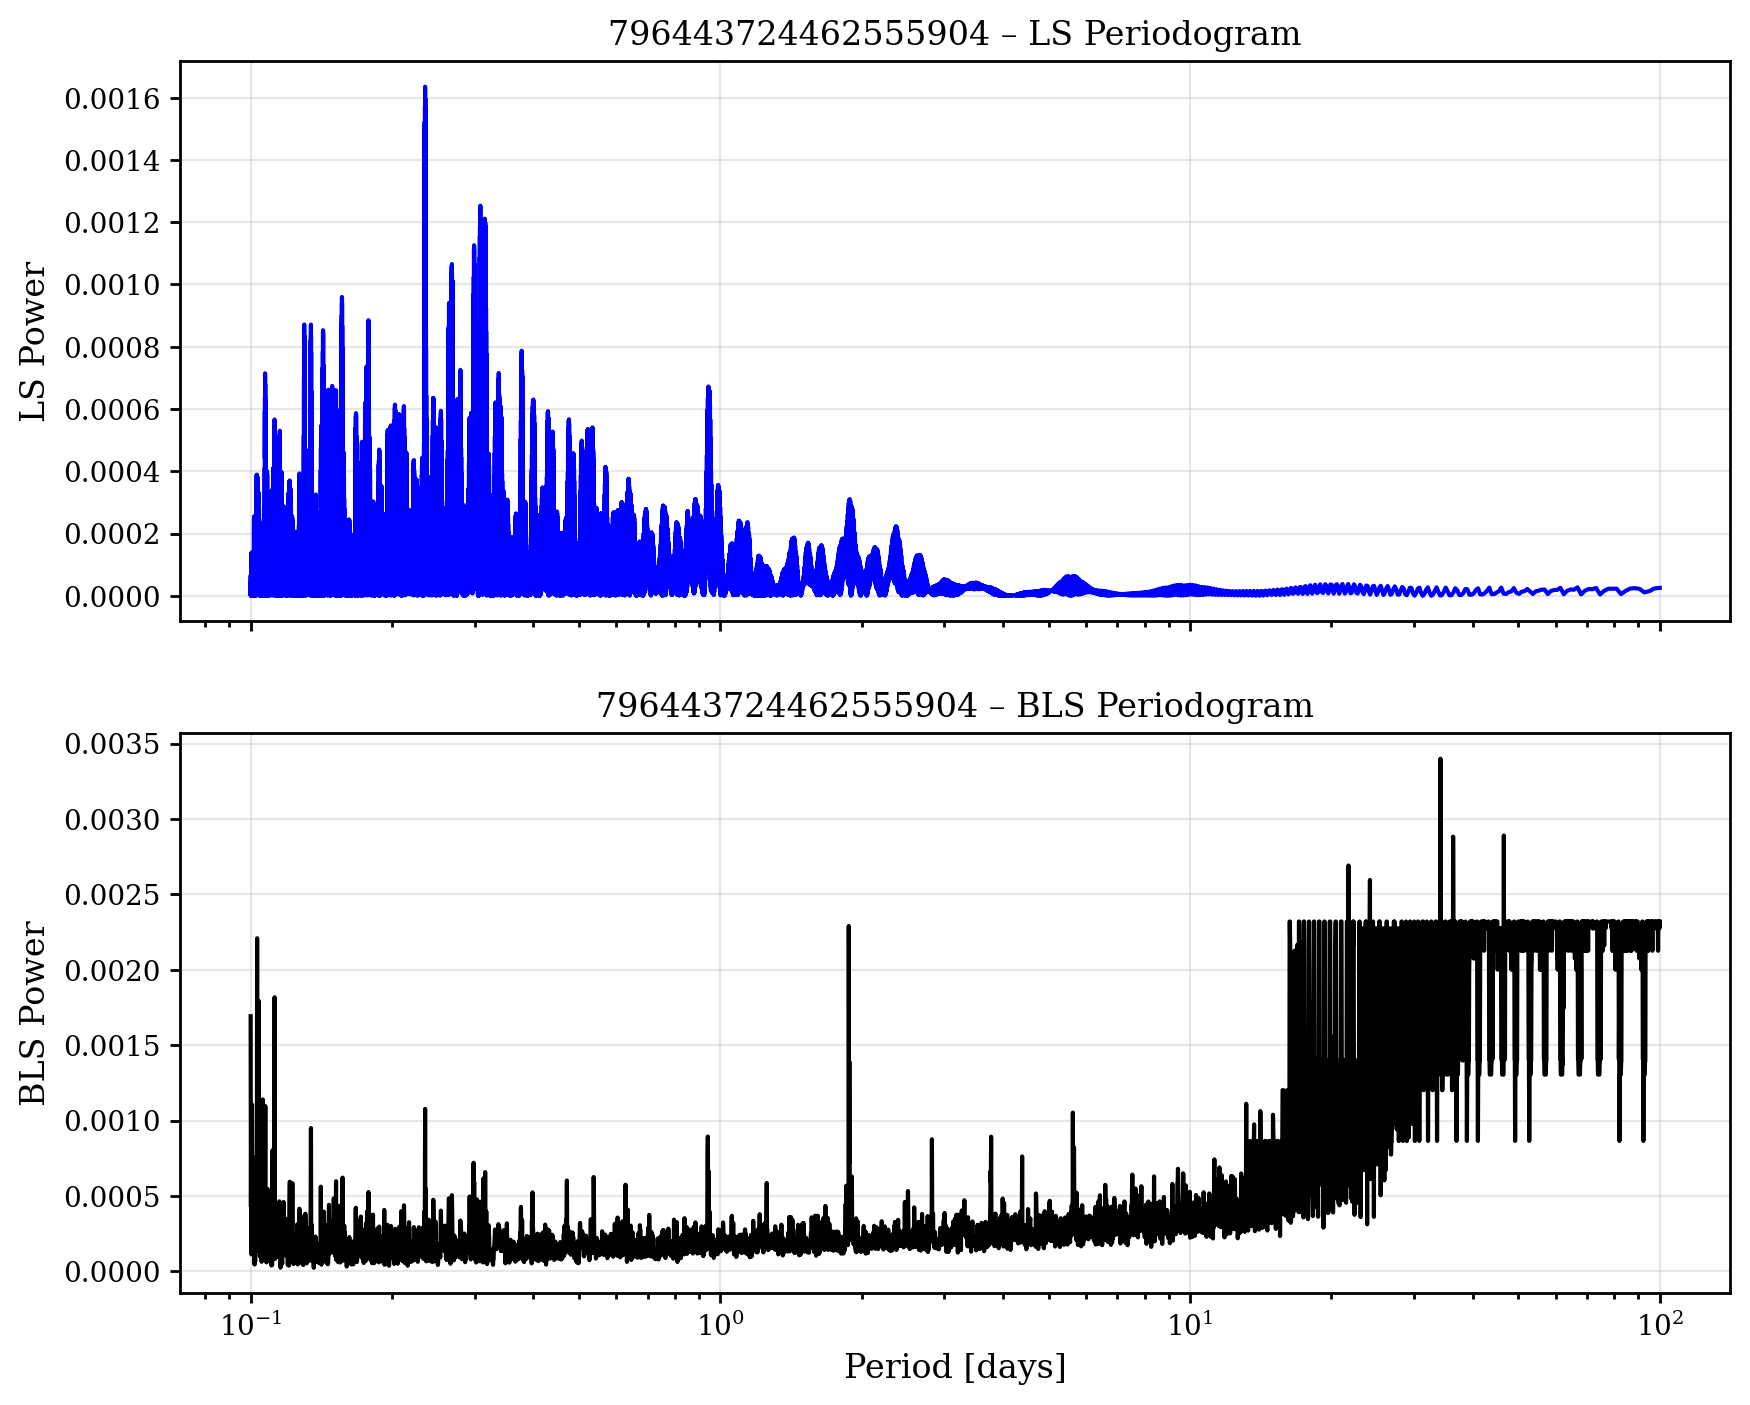

In [13]:
# Let's analyze all of the light curves (just one) simultaneously and plot the periodogram to confirm that this is an eclipsing binary.
results = tess_analyzer.batch_analyze()
tess_analyzer.batch_plot_folded()
tess_analyzer.batch_plot_periodograms()

### Part 3: Synthetic Populations
Now that we've tested it out on real data, let's do synthetic data to see how well our model fares (this is the reverse order of how these experiments typically work!) Let's generate a synthetic cluster using the `isochrones` package and see how well our fit code fares.

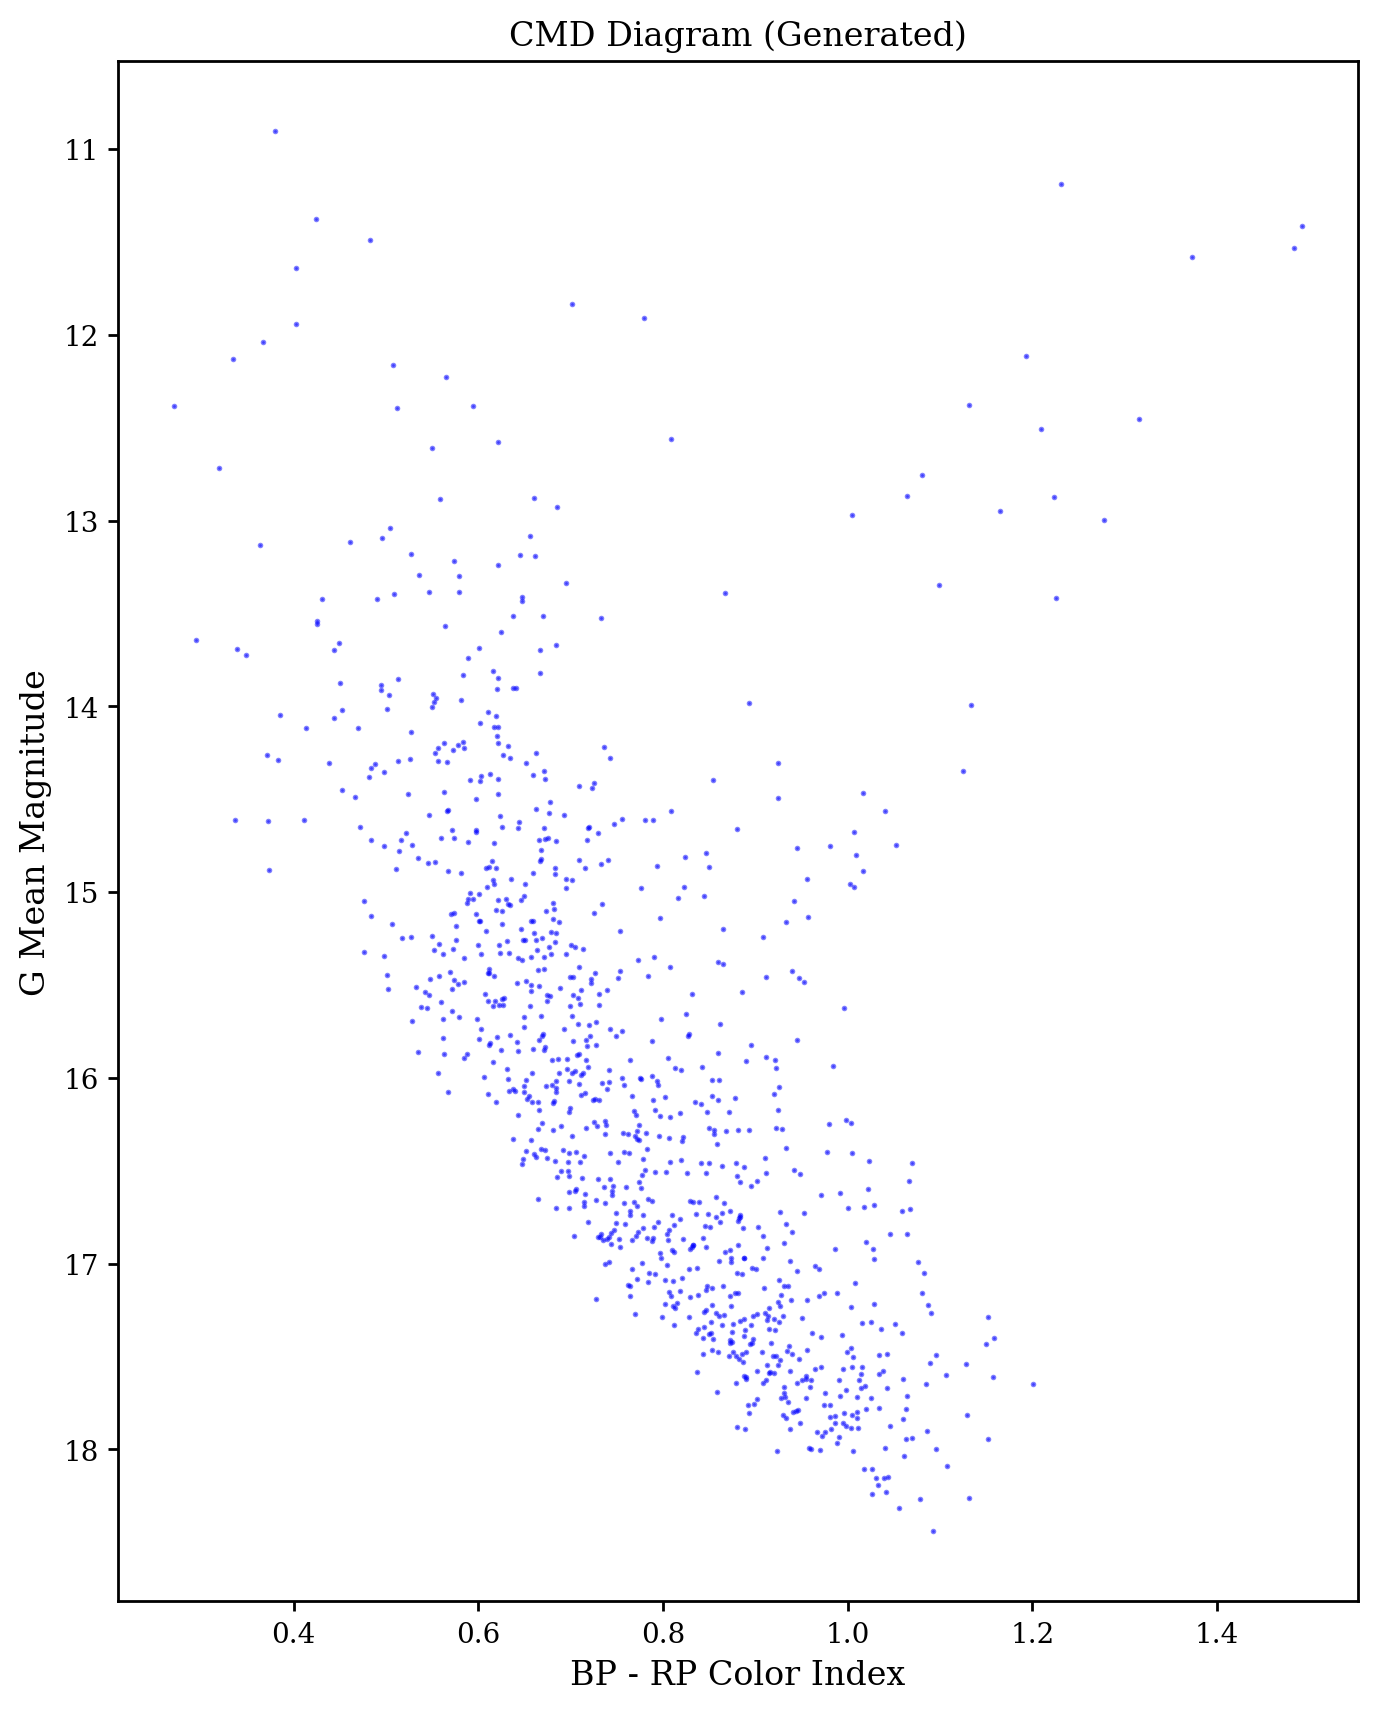

(<Figure size 800x1000 with 1 Axes>,
 <Axes: title={'center': 'CMD Diagram (Generated)'}, xlabel='BP - RP Color Index', ylabel='G Mean Magnitude'>)

In [14]:
# Let's design an isochrone synthesizer and generate 1000 points.

synthesizer = IsochroneSynthesizer(fB=0.2)
synthetic_df = synthesizer.generate(1000)
synthesizer.plot_hr_diagram()

100%|██████████| 1000/1000 [03:02<00:00,  5.49it/s]
2025-11-13 12:20:21,957 - WARNING - Too few points to create valid contours
2025-11-13 12:20:21,975 - WARNING - Too few points to create valid contours
2025-11-13 12:20:21,985 - WARNING - Too few points to create valid contours
2025-11-13 12:20:22,002 - WARNING - Too few points to create valid contours
2025-11-13 12:20:22,020 - WARNING - Too few points to create valid contours
2025-11-13 12:20:22,045 - WARNING - Too few points to create valid contours
2025-11-13 12:20:22,063 - WARNING - Too few points to create valid contours
2025-11-13 12:20:22,080 - WARNING - Too few points to create valid contours
2025-11-13 12:20:22,090 - WARNING - Too few points to create valid contours


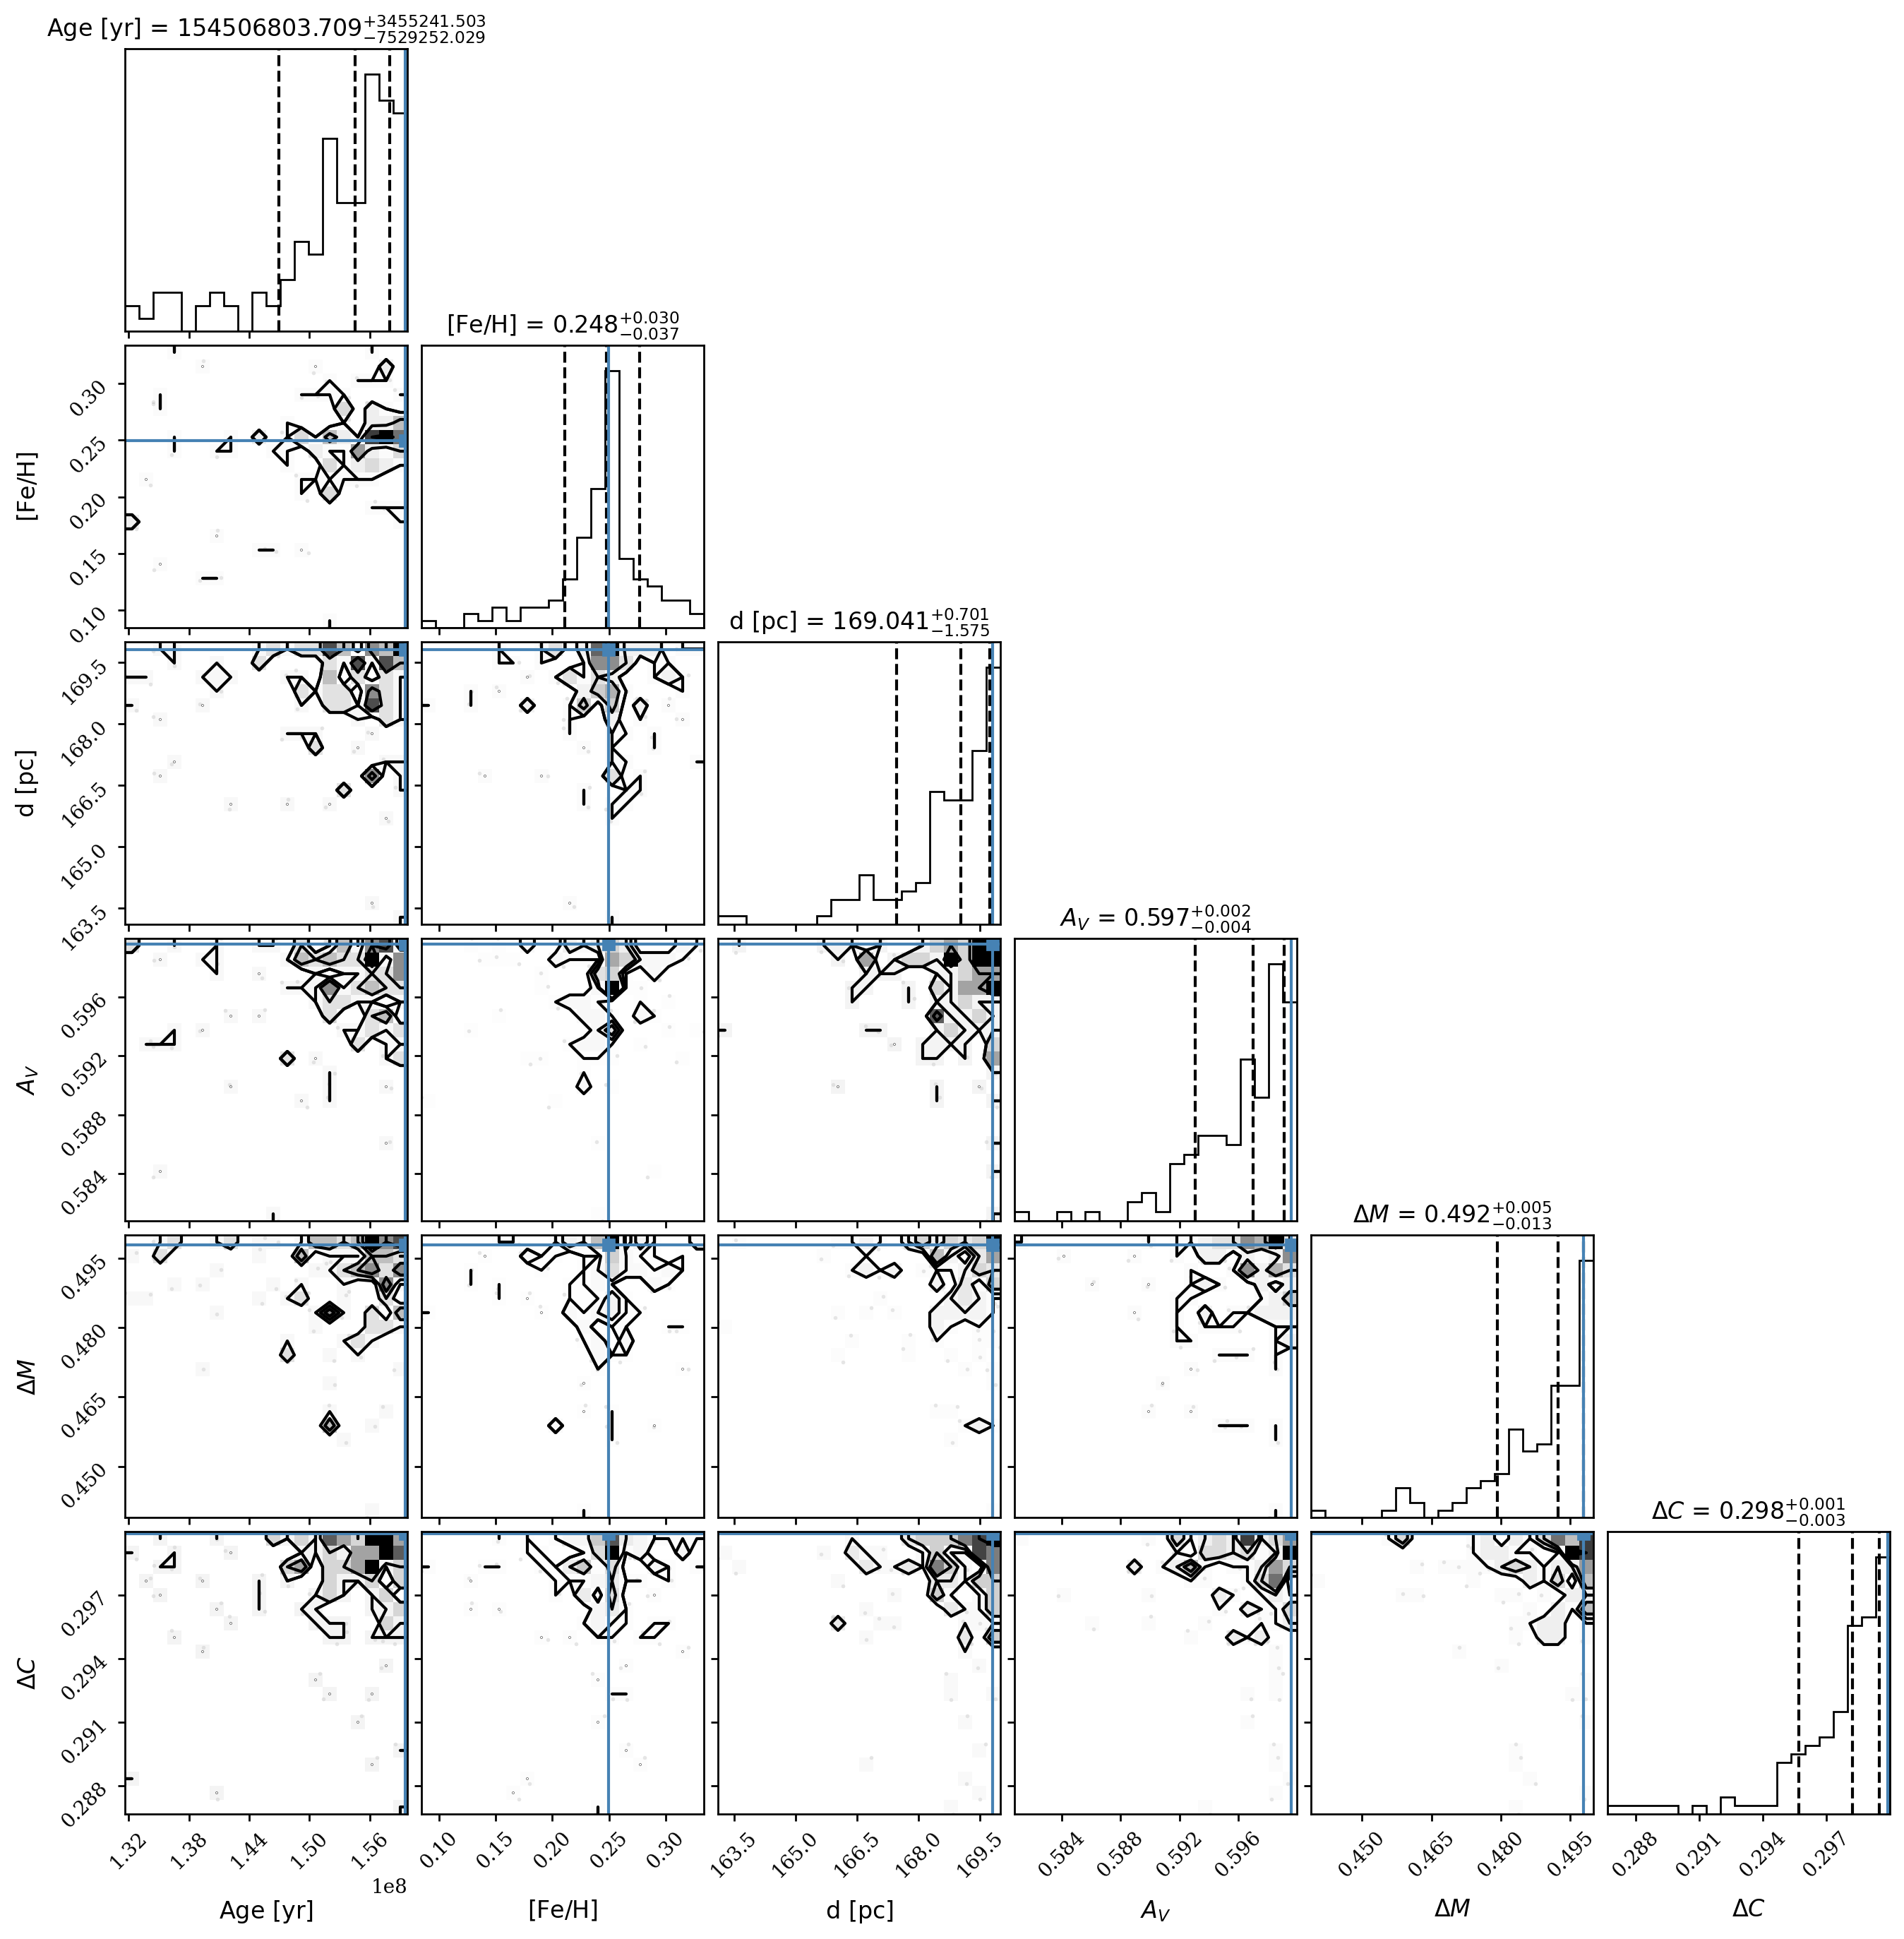

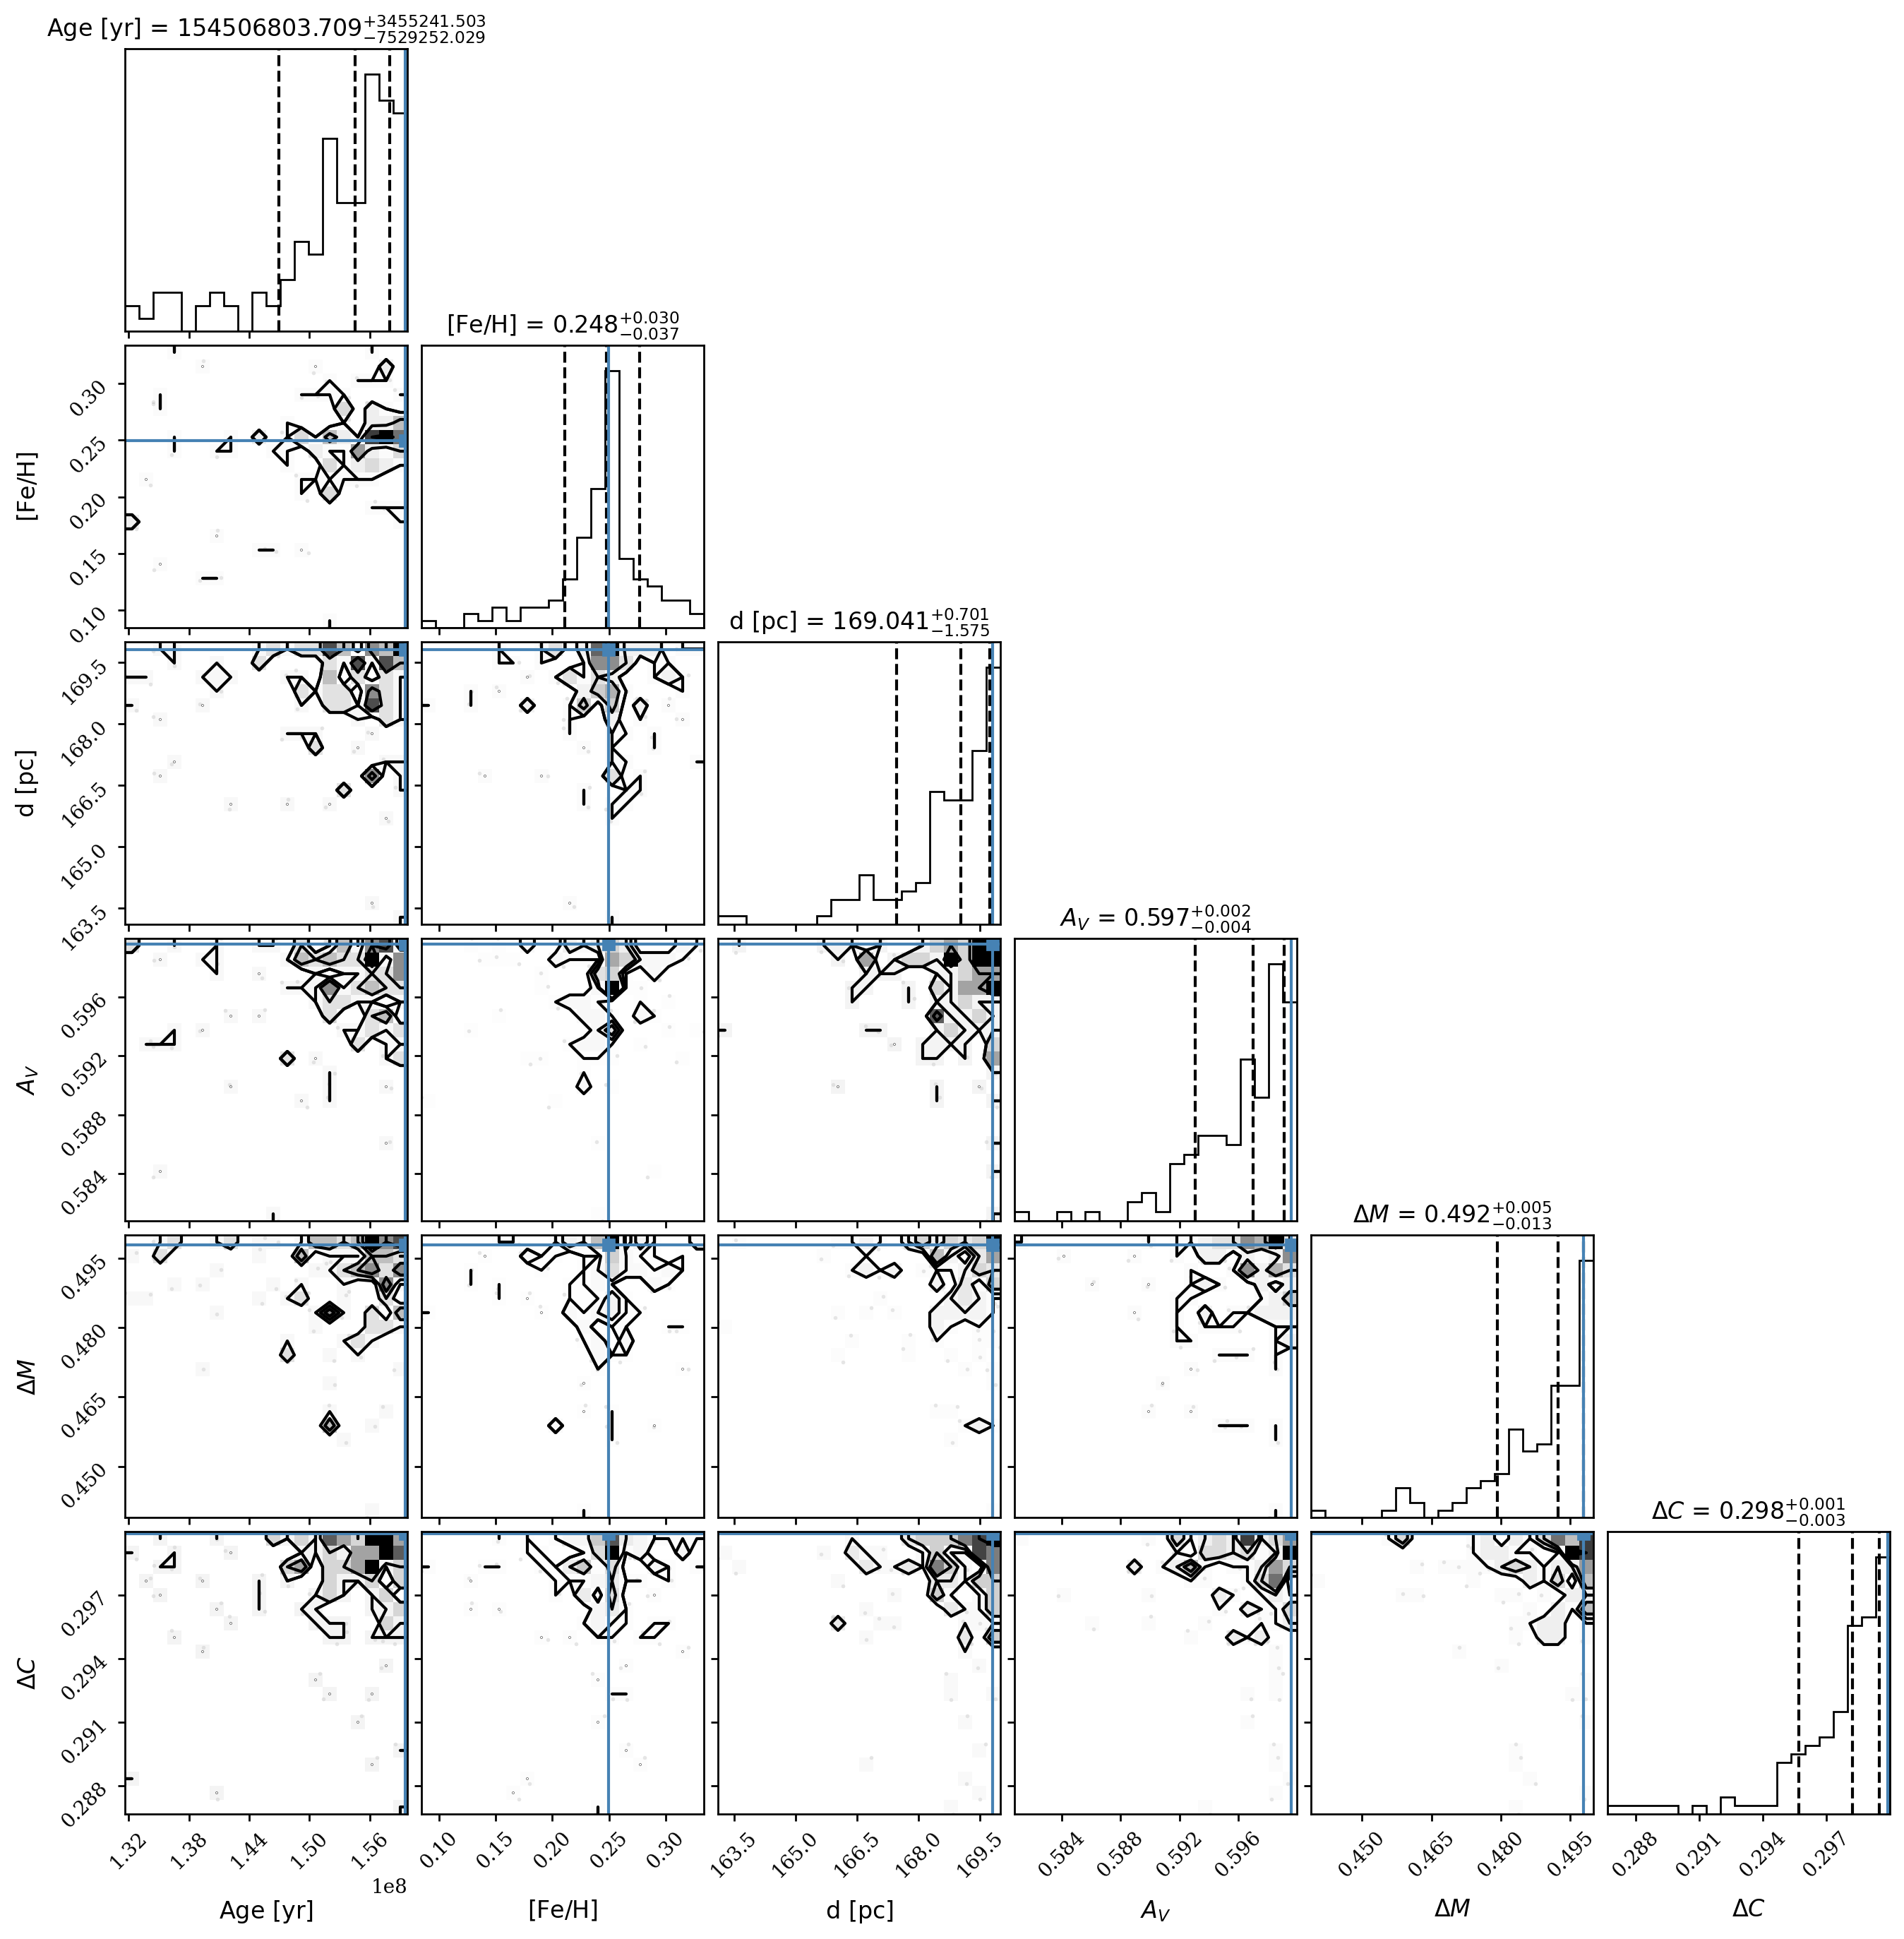

In [15]:
# Repeat the same steps as Part 1.
synthetic_fitter = MISTFitter(data=synthetic_df)
synthetic_sampler = synthetic_fitter.sample_cluster(n_walkers=32, n_burn=200, n_steps=1000)
synthetic_fitter.plot_corner(synthetic_sampler, discard=200, thin=200)

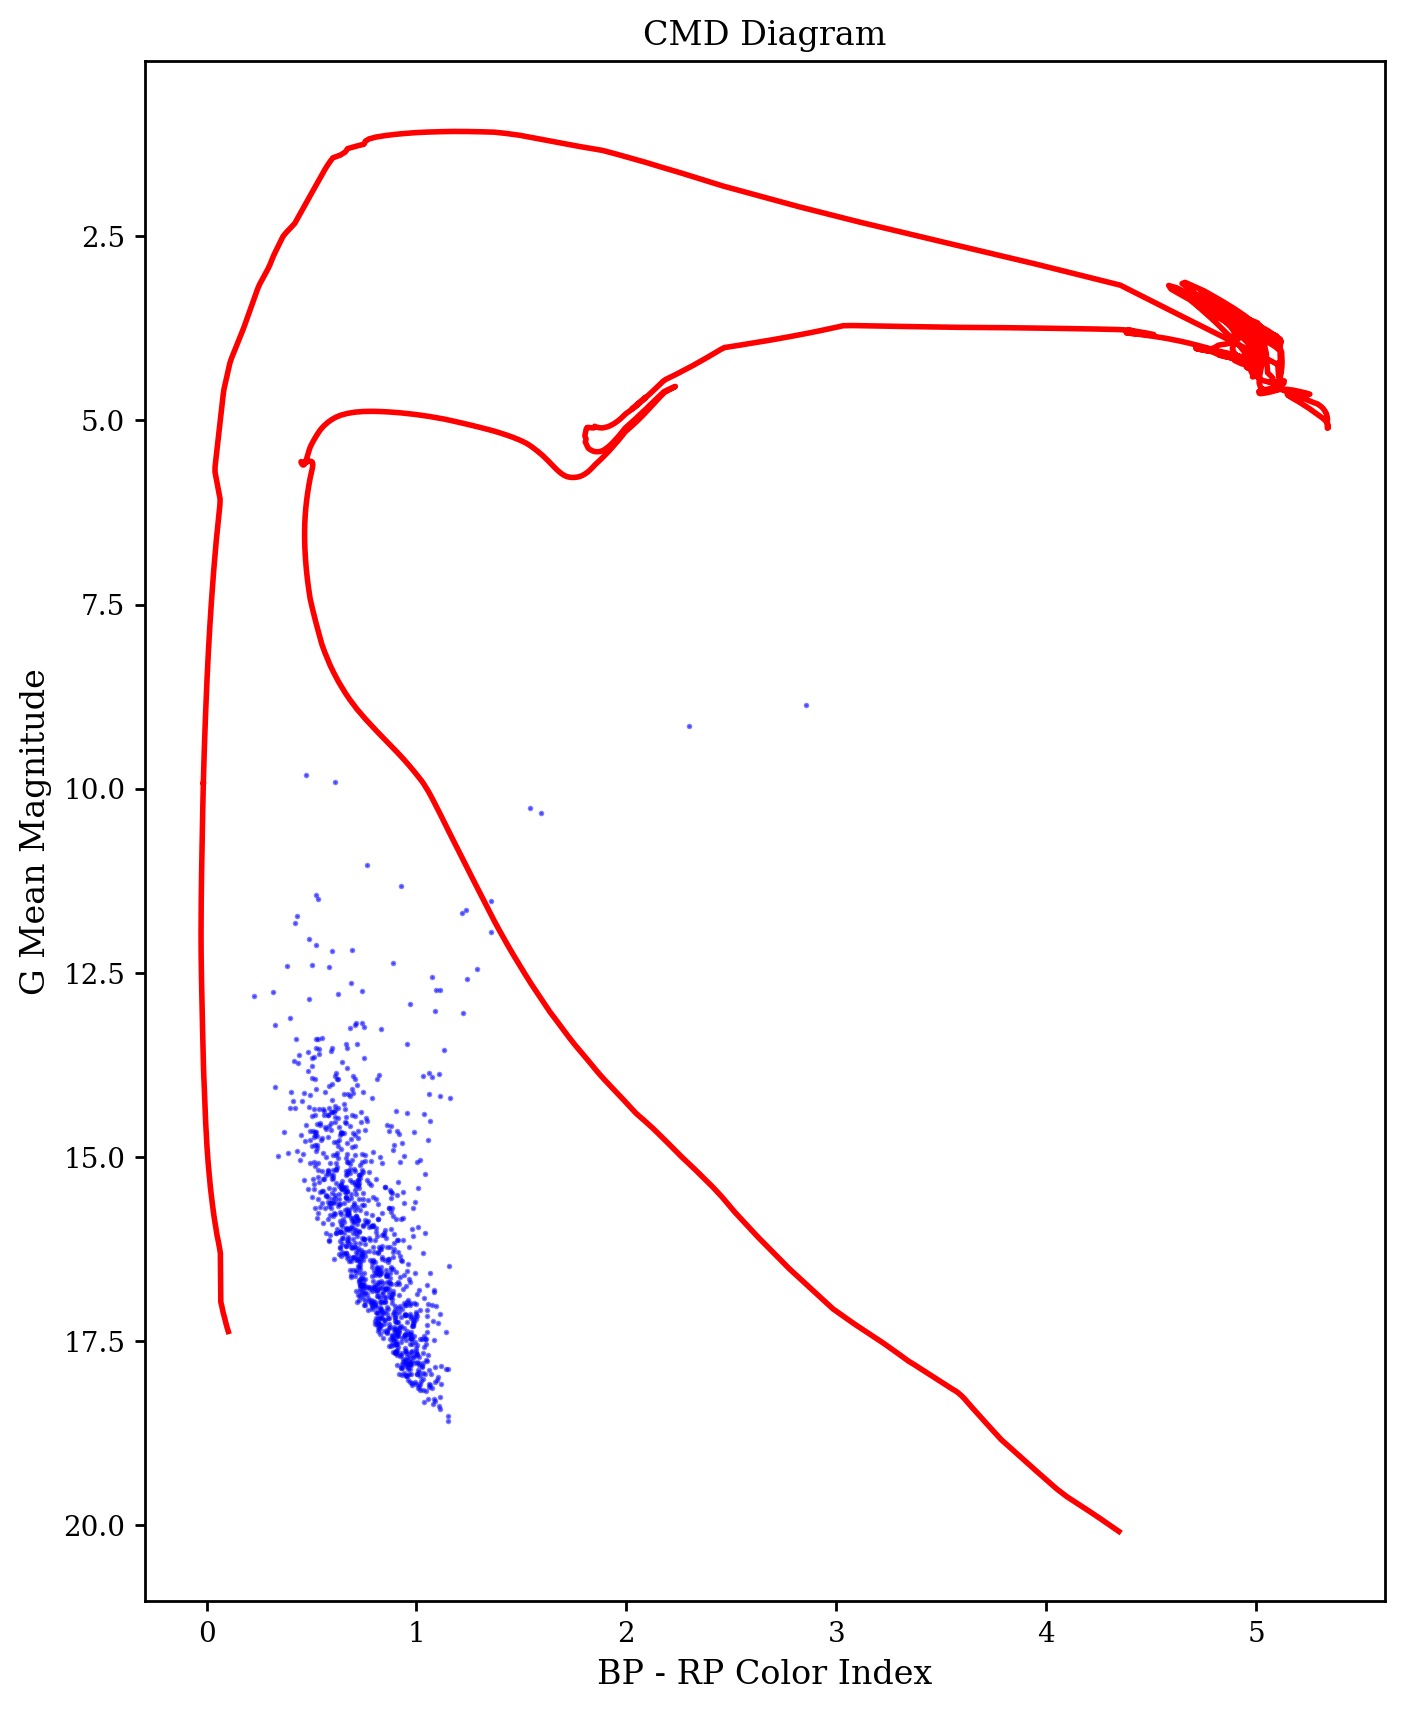

(<Figure size 800x1000 with 1 Axes>,
 <Axes: title={'center': 'CMD Diagram'}, xlabel='BP - RP Color Index', ylabel='G Mean Magnitude'>)

In [16]:
# We get the best parameters here too
synthetic_best_params = synthetic_fitter.get_best_model()
synthetic_fitter.plot_isochrone(synthetic_best_params)

2025-11-13 12:20:23,190 - INFO - Starting EM fit
2025-11-13 12:20:23,191 - INFO - Initial weights: [0.8 0.2 0. ]
  0%|          | 0/40 [00:00<?, ?it/s]2025-11-13 12:20:25,392 - INFO - lnL stats | single: mean=-0.84 max=10.85, binary: mean=8.35 max=79.45, field: mean=0.00 max=0.00
2025-11-13 12:20:25,394 - INFO - Updated mixture weights: [5.33268998e-01 4.66234724e-01 4.96277916e-04]
  2%|▎         | 1/40 [00:02<01:25,  2.20s/it]2025-11-13 12:20:25,397 - INFO - lnL stats | single: mean=-0.84 max=10.85, binary: mean=8.35 max=79.45, field: mean=0.00 max=0.00
2025-11-13 12:20:25,398 - INFO - Updated mixture weights: [0.4383664  0.48580683 0.07582677]
2025-11-13 12:20:25,400 - INFO - lnL stats | single: mean=-0.84 max=10.85, binary: mean=8.35 max=79.45, field: mean=0.00 max=0.00
2025-11-13 12:20:25,400 - INFO - Updated mixture weights: [0.28207404 0.47325757 0.24466839]
2025-11-13 12:20:25,404 - INFO - lnL stats | single: mean=-0.84 max=10.85, binary: mean=8.35 max=79.45, field: mean=0.00 m

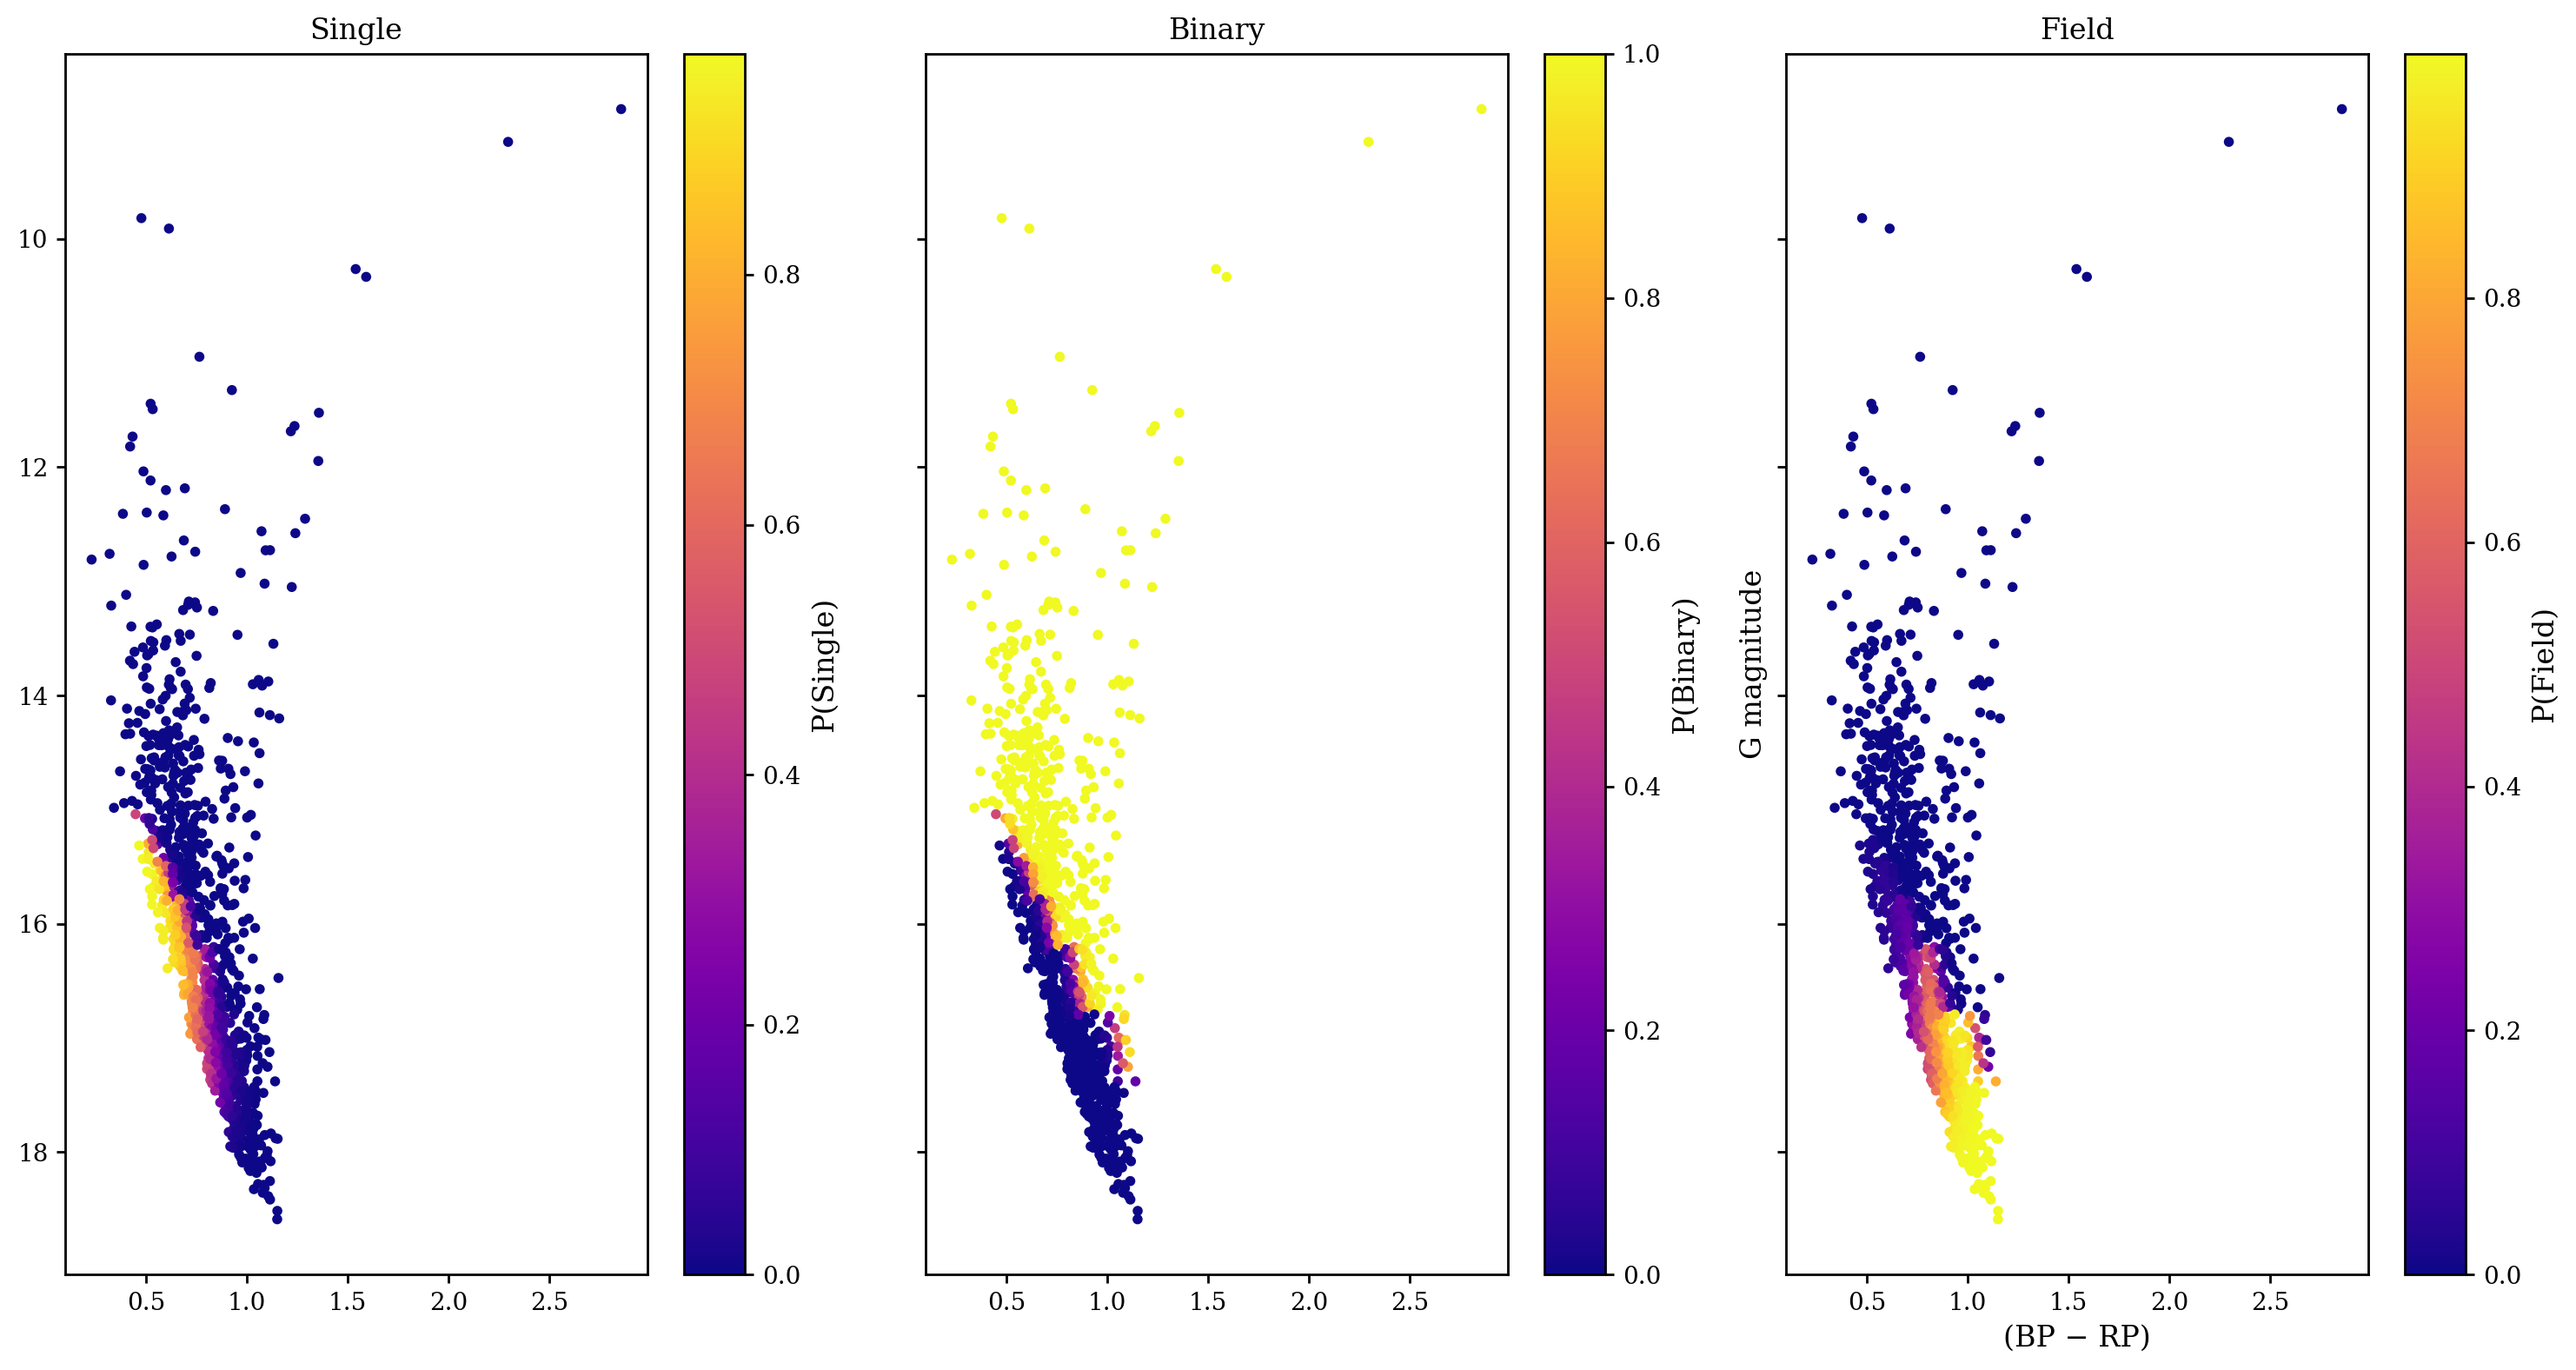

2025-11-13 12:20:25,836 - INFO - The optimal fit weights for the synthetic population are: [f_single, f_binary, f_field] = [0.18492246 0.47073143 0.34434612]


In [17]:
# Use the previous single star isochrone fit as a prior to inform the binary mixture fit.
synth_bfitter = BinaryMixtureFitter(data=synthetic_df)
synth_bfitter.fit(theta=synthetic_best_params)
synth_bfitter.plot()

logging.info(
    f"The optimal fit weights for the synthetic population are: [f_single, f_binary, f_field] = {synth_bfitter.get_mixture_weights()}"
)